In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2.aruco as aruco
from tqdm import tqdm
# import pytables

In [2]:
# conda install tqdm

### Track the aruco markers
This code tracks the markers, and also creates a video with the first 1000 frames tracked.
You can play around for example also visualizing the corners on the tracked marker, etc


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import json


# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered_ema.MP4'

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Smoothing factor for exponential moving average
alpha = 0.1  # Adjust between 0 and 1; lower values mean more smoothing

# Initialize smoothed centroids history
smoothed_centroids_history = {}

### Try overlapping tiles or offset tile when only 2 are found (this first)
# Function to detect ArUco markers in image tiles and compute centroids
# Function to detect ArUco markers in image tiles and merge results
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=200):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []
    centroids = {}

    # Collect detections from all tiles
    all_corners = []
    all_ids = []
    all_centroids = {}

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            start_x = max(0, x - overlap)
            start_y = max(0, y - overlap)
            end_x = min(w, x + tile_size + overlap)
            end_y = min(h, y + tile_size + overlap)

            expanded_tile = frame[start_y:end_y, start_x:end_x]
            
            # Convert to grayscale and detect markers in the expanded tile
            gray = cv2.cvtColor(expanded_tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        # Adjust corner coordinates relative to the original frame
                        corner[:, :, 0] += start_x
                        corner[:, :, 1] += start_y

                        all_corners.append(corner)
                        all_ids.append(id_scalar)

                        # Compute centroid
                        centroid = np.mean(corner[0], axis=0)
                        if id_scalar in all_centroids:
                            # Average centroids if marker appears in multiple tiles
                            all_centroids[id_scalar].append(centroid)
                        else:
                            all_centroids[id_scalar] = [centroid]

    # Merge detections from all tiles
    for id_scalar, centroids_list in all_centroids.items():
        if len(centroids_list) > 1:
            # Average centroids detected in multiple tiles
            merged_centroid = np.mean(centroids_list, axis=0)
        else:
            merged_centroid = centroids_list[0]
        centroids[id_scalar] = merged_centroid

    # Draw detected markers on the frame
    if all_ids:
        detected_ids = np.array(all_ids)
        detected_corners = all_corners
        cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
    else:
        detected_ids = None

    return frame, centroids, detected_ids
    

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

first_frame_detected, first_centroids, first_ids = detect_aruco_markers_in_tiles(first_frame)
if first_ids is None or len(first_ids) < 2:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

# Initialize smoothed centroids with the first frame's centroids
for id_, centroid in first_centroids.items():
    smoothed_centroids_history[id_] = centroid.copy()

# Write the first frame to the output video
out.write(first_frame_detected)

# Initialize previous valid transformation
prev_frame_index = 0
prev_transformation = None
prev_matched_ids = first_ids.copy()
prev_smoothed_centroids = first_centroids.copy()

# Buffer to store frames needing interpolation
buffered_frames = []
buffered_indices = []

frame_count = 0
max_frames = 100  # Limit processing to the first 500 frames

unsmoothed_centroids_history = {}
smoothed_centroids_history_full = {}

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    detected_frame, centroids, ids = detect_aruco_markers_in_tiles(frame)
    if ids is not None and len(ids) >= 2:
        smoothed_centroids = {}
        for id_ in ids:
            centroid = centroids[id_]
    
            # Initialize history for unsmoothed centroids if not present
            if id_ not in unsmoothed_centroids_history:
                unsmoothed_centroids_history[id_] = []
            unsmoothed_centroids_history[id_].append(centroid.tolist())
    
            # Apply exponential smoothing for smoothed centroids
            if id_ in smoothed_centroids_history:
                smoothed_centroid = alpha * centroid + (1 - alpha) * smoothed_centroids_history[id_]
                smoothed_centroids_history[id_] = smoothed_centroid.copy()
            else:
                smoothed_centroid = centroid.copy()
                smoothed_centroids_history[id_] = smoothed_centroid.copy()
    
            # Initialize history for smoothed centroids if not present
            if id_ not in smoothed_centroids_history_full:
                smoothed_centroids_history_full[id_] = []
            smoothed_centroids_history_full[id_].append(smoothed_centroid.tolist())
    
            # Store smoothed centroids for the current frame
            smoothed_centroids[id_] = smoothed_centroid
        
    else:
        smoothed_centroids = {}
        print(f"[INFO] Frame {frame_count}: Not enough valid markers detected.")

    # Find common markers between current frame and the first frame
    matched_ids = set(first_ids).intersection(set(ids)) if ids is not None else set()
    if len(matched_ids) >= 2:
        # Use centroids of matched markers for transformation estimation
        pts_src = []
        pts_dst = []
        for id_ in matched_ids:
            pts_src.append(smoothed_centroids[id_])
            pts_dst.append(first_centroids[id_])

        pts_src = np.array(pts_src)
        pts_dst = np.array(pts_dst)

        if len(matched_ids) >= 3:
            # Compute affine transformation
            M, inliers = cv2.estimateAffine2D(pts_src, pts_dst, method=cv2.RANSAC)
        else:
            # Compute similarity transformation
            
            M, inliers = cv2.estimateAffinePartial2D(pts_src, pts_dst, method=cv2.RANSAC)

        if M is not None:
            # We have a valid transformation
            # If we have buffered frames, interpolate transformations
            if buffered_frames:
                # Interpolate transformations between prev_transformation and M
                num_buffered = len(buffered_frames)
                for i, (buf_frame, buf_index) in enumerate(zip(buffered_frames, buffered_indices)):
                    t = (i + 1) / (num_buffered + 1)
                    # Linear interpolation of transformation matrices
                    interpolated_M = (1 - t) * prev_transformation + t * M
                    warped_frame = cv2.warpAffine(buf_frame, interpolated_M, (width, height))
                    out.write(warped_frame)
                # Clear the buffers
                buffered_frames = []
                buffered_indices = []

            # Apply transformation to current frame
            warped_frame = cv2.warpAffine(frame, M, (width, height))
            out.write(warped_frame)

            # Update previous valid transformation
            prev_transformation = M.copy()
            prev_frame_index = frame_count
            prev_matched_ids = ids.copy()
            prev_smoothed_centroids = smoothed_centroids.copy()
        else:
            print(f"[INFO] Frame {frame_count}: Transformation could not be computed.")
            # Buffer the frame
            buffered_frames.append(frame)
            buffered_indices.append(frame_count)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough matched markers.")
        # Buffer the frame
        buffered_frames.append(frame)
        buffered_indices.append(frame_count)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

# After processing all frames, handle any remaining buffered frames
if buffered_frames and prev_transformation is not None:
    print("[INFO] Processing remaining buffered frames at the end of the video.")
    for buf_frame in buffered_frames:
        # Use the last known valid transformation
        warped_frame = cv2.warpAffine(buf_frame, prev_transformation, (width, height))
        out.write(warped_frame)
elif buffered_frames:
    print("[INFO] No valid transformation available for remaining buffered frames. Writing original frames.")
    for buf_frame in buffered_frames:
        out.write(buf_frame)

# Release video objects
cap.release()
out.release()
print("[INFO] Video processing complete.")



# Save the data to a JSON file
output_data = {
    "non_smoothed_centroids": {str(k): np.array(v).tolist() for k, v in unsmoothed_centroids_history.items()},
    "smoothed_centroids": {str(k): np.array(v).tolist() for k, v in smoothed_centroids_history_full.items()},
}

with open('centroids_data_moving_ema.json', 'w') as f:
    json.dump(output_data, f)

print("[INFO] Centroids data saved to 'centroids_data_moving_ema.json'")

Processed frame 0
[INFO] Video processing complete.
[INFO] Centroids data saved to 'centroids_data_moving_ema.json'


In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_070126703_DJI_0257.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_070126703_DJI_0257_registered_ema_a04.MP4'

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Smoothing factor for exponential moving average
alpha = 0.4  # Adjust between 0 and 1; lower values mean more smoothing

# Initialize smoothed centroids history
smoothed_centroids_history = {}

# Frame range for processing
start_frame = 500  # Change to your desired starting frame
end_frame = 1100   # Change to your desired ending frame


# Function to detect ArUco markers in image tiles and merge results
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=200):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []
    centroids = {}

    # Collect detections from all tiles
    all_corners = []
    all_ids = []
    all_centroids = {}

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            start_x = max(0, x - overlap)
            start_y = max(0, y - overlap)
            end_x = min(w, x + tile_size + overlap)
            end_y = min(h, y + tile_size + overlap)

            expanded_tile = frame[start_y:end_y, start_x:end_x]
            
            # Convert to grayscale and detect markers in the expanded tile
            gray = cv2.cvtColor(expanded_tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        # Adjust corner coordinates relative to the original frame
                        corner[:, :, 0] += start_x
                        corner[:, :, 1] += start_y

                        all_corners.append(corner)
                        all_ids.append(id_scalar)

                        # Compute centroid
                        centroid = np.mean(corner[0], axis=0)
                        if id_scalar in all_centroids:
                            # Average centroids if marker appears in multiple tiles
                            all_centroids[id_scalar].append(centroid)
                        else:
                            all_centroids[id_scalar] = [centroid]

    # Merge detections from all tiles
    for id_scalar, centroids_list in all_centroids.items():
        if len(centroids_list) > 1:
            # Average centroids detected in multiple tiles
            merged_centroid = np.mean(centroids_list, axis=0)
        else:
            merged_centroid = centroids_list[0]
        centroids[id_scalar] = merged_centroid

    # Draw detected markers on the frame
    if all_ids:
        detected_ids = np.array(all_ids)
        detected_corners = all_corners
        cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
    else:
        detected_ids = None

    return frame, centroids, detected_ids
    

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Set the starting frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

first_frame_detected, first_centroids, first_ids = detect_aruco_markers_in_tiles(first_frame)
if first_ids is None or len(first_ids) < 2:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

# Initialize smoothed centroids with the first frame's centroids
for id_, centroid in first_centroids.items():
    smoothed_centroids_history[id_] = centroid.copy()

# Write the first frame to the output video
out.write(first_frame_detected)

# Initialize previous valid transformation
prev_frame_index = 0
prev_transformation = None
prev_matched_ids = first_ids.copy()
prev_smoothed_centroids = first_centroids.copy()

# Buffer to store frames needing interpolation
buffered_frames = []
buffered_indices = []

frame_count = start_frame

while cap.isOpened() and frame_count <= end_frame:
    ret, frame = cap.read()
    if not ret:
        break

    detected_frame, centroids, ids = detect_aruco_markers_in_tiles(frame)
    if ids is not None and len(ids) >= 2:
        smoothed_centroids = {}
        for id_ in ids:
            centroid = centroids[id_]
    
            # Initialize history for unsmoothed centroids if not present
            if id_ not in unsmoothed_centroids_history:
                unsmoothed_centroids_history[id_] = []
            unsmoothed_centroids_history[id_].append(centroid.tolist())
    
            # Apply exponential smoothing for smoothed centroids
            if id_ in smoothed_centroids_history:
                smoothed_centroid = alpha * centroid + (1 - alpha) * smoothed_centroids_history[id_]
                smoothed_centroids_history[id_] = smoothed_centroid.copy()
            else:
                smoothed_centroid = centroid.copy()
                smoothed_centroids_history[id_] = smoothed_centroid.copy()
    
            # Initialize history for smoothed centroids if not present
            if id_ not in smoothed_centroids_history_full:
                smoothed_centroids_history_full[id_] = []
            smoothed_centroids_history_full[id_].append(smoothed_centroid.tolist())
    
            # Store smoothed centroids for the current frame
            smoothed_centroids[id_] = smoothed_centroid
        
    else:
        smoothed_centroids = {}
        print(f"[INFO] Frame {frame_count}: Not enough valid markers detected.")

    # Find common markers between current frame and the first frame
    matched_ids = set(first_ids).intersection(set(ids)) if ids is not None else set()
    if len(matched_ids) >= 2:
        # Use centroids of matched markers for transformation estimation
        pts_src = []
        pts_dst = []
        for id_ in matched_ids:
            pts_src.append(smoothed_centroids[id_])
            pts_dst.append(first_centroids[id_])

        pts_src = np.array(pts_src)
        pts_dst = np.array(pts_dst)

        if len(matched_ids) >= 3:
            # Compute affine transformation
            M, inliers = cv2.estimateAffine2D(pts_src, pts_dst, method=cv2.RANSAC)
        else:
            # Compute similarity transformation
            
            M, inliers = cv2.estimateAffinePartial2D(pts_src, pts_dst, method=cv2.RANSAC)

        if M is not None:
            # We have a valid transformation
            # If we have buffered frames, interpolate transformations
            if buffered_frames:
                # Interpolate transformations between prev_transformation and M
                num_buffered = len(buffered_frames)
                for i, (buf_frame, buf_index) in enumerate(zip(buffered_frames, buffered_indices)):
                    t = (i + 1) / (num_buffered + 1)
                    # Linear interpolation of transformation matrices
                    interpolated_M = (1 - t) * prev_transformation + t * M
                    warped_frame = cv2.warpAffine(buf_frame, interpolated_M, (width, height))
                    out.write(warped_frame)
                # Clear the buffers
                buffered_frames = []
                buffered_indices = []

            # Apply transformation to current frame
            warped_frame = cv2.warpAffine(frame, M, (width, height))
            out.write(warped_frame)

            # Update previous valid transformation
            prev_transformation = M.copy()
            prev_frame_index = frame_count
            prev_matched_ids = ids.copy()
            prev_smoothed_centroids = smoothed_centroids.copy()
        else:
            print(f"[INFO] Frame {frame_count}: Transformation could not be computed.")
            # Buffer the frame
            buffered_frames.append(frame)
            buffered_indices.append(frame_count)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough matched markers.")
        # Buffer the frame
        buffered_frames.append(frame)
        buffered_indices.append(frame_count)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

# After processing all frames, handle any remaining buffered frames
if buffered_frames and prev_transformation is not None:
    print("[INFO] Processing remaining buffered frames at the end of the video.")
    for buf_frame in buffered_frames:
        # Use the last known valid transformation
        warped_frame = cv2.warpAffine(buf_frame, prev_transformation, (width, height))
        out.write(warped_frame)
elif buffered_frames:
    print("[INFO] No valid transformation available for remaining buffered frames. Writing original frames.")
    for buf_frame in buffered_frames:
        out.write(buf_frame)

# Release video objects
cap.release()
out.release()
print("[INFO] Video processing complete.")

# Save the data to a JSON file
output_data = {
    "non_smoothed_centroids": {str(k): np.array(v).tolist() for k, v in unsmoothed_centroids_history.items()},
    "smoothed_centroids": {str(k): np.array(v).tolist() for k, v in smoothed_centroids_history_full.items()},
}

with open('centroids_data_moving_ema.json', 'w') as f:
    json.dump(output_data, f)

print("[INFO] Centroids data saved to 'centroids_data_moving_ema.json'")


Processed frame 500
Processed frame 600
Processed frame 700
Processed frame 800
Processed frame 900
Processed frame 1000
Processed frame 1100
[INFO] Video processing complete.
[INFO] Centroids data saved to 'centroids_data_moving_ema.json'


## Using a rolling average

In [46]:
import cv2
import numpy as np
import collections
import json

# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_070126703_DJI_0257.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_070126703_DJI_0257_rolling_avg.MP4'

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Rolling average window size
window_size = 2  # Adjust based on your smoothing preference

# Initialize rolling average buffers for marker centroids
rolling_centroids_history = {}

# Frame range for processing
start_frame = 800  # Change to your desired starting frame
end_frame = 1300   # Change to your desired ending frame


# Function to detect ArUco markers in image tiles and merge results
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=200):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []
    centroids = {}

    # Collect detections from all tiles
    all_corners = []
    all_ids = []
    all_centroids = {}

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            start_x = max(0, x - overlap)
            start_y = max(0, y - overlap)
            end_x = min(w, x + tile_size + overlap)
            end_y = min(h, y + tile_size + overlap)

            expanded_tile = frame[start_y:end_y, start_x:end_x]
            
            # Convert to grayscale and detect markers in the expanded tile
            gray = cv2.cvtColor(expanded_tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        # Adjust corner coordinates relative to the original frame
                        corner[:, :, 0] += start_x
                        corner[:, :, 1] += start_y

                        all_corners.append(corner)
                        all_ids.append(id_scalar)

                        # Compute centroid
                        centroid = np.mean(corner[0], axis=0)
                        if id_scalar in all_centroids:
                            # Append centroid if marker appears in multiple tiles
                            all_centroids[id_scalar].append(centroid)
                        else:
                            all_centroids[id_scalar] = [centroid]

    # Merge detections from all tiles
    for id_scalar, centroids_list in all_centroids.items():
        if len(centroids_list) > 1:
            # Average centroids detected in multiple tiles
            merged_centroid = np.mean(centroids_list, axis=0)
        else:
            merged_centroid = centroids_list[0]
        centroids[id_scalar] = merged_centroid

    # Draw detected markers on the frame
    if all_ids:
        detected_ids = np.array(all_ids)
        detected_corners = all_corners
        cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
    else:
        detected_ids = None

    return frame, centroids, detected_ids
    

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Set the starting frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

first_frame_detected, first_centroids, first_ids = detect_aruco_markers_in_tiles(first_frame)
if first_ids is None or len(first_ids) < 2:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

# Initialize rolling average buffers for centroids
for id_, centroid in first_centroids.items():
    rolling_centroids_history[id_] = collections.deque([centroid], maxlen=window_size)

# Write the first frame to the output video
out.write(first_frame_detected)

# Initialize previous valid transformation
prev_transformation = None

frame_count = start_frame

while cap.isOpened() and frame_count <= end_frame:
    ret, frame = cap.read()
    if not ret:
        break

    detected_frame, centroids, ids = detect_aruco_markers_in_tiles(frame)
    if ids is not None and len(ids) >= 2:
        smoothed_centroids = {}
        for id_ in ids:
            centroid = centroids[id_]
    
            # Update rolling average buffer
            if id_ not in rolling_centroids_history:
                rolling_centroids_history[id_] = collections.deque(maxlen=window_size)
            rolling_centroids_history[id_].append(centroid)

            # Compute rolling average
            smoothed_centroid = np.mean(rolling_centroids_history[id_], axis=0)
            smoothed_centroids[id_] = smoothed_centroid
        
    else:
        smoothed_centroids = {}
        print(f"[INFO] Frame {frame_count}: Not enough valid markers detected.")

    # Find common markers between current frame and the first frame
    matched_ids = set(first_ids).intersection(set(ids)) if ids is not None else set()
    if len(matched_ids) >= 2:
        # Use centroids of matched markers for transformation estimation
        pts_src = []
        pts_dst = []
        for id_ in matched_ids:
            pts_src.append(smoothed_centroids[id_])
            pts_dst.append(first_centroids[id_])

        pts_src = np.array(pts_src)
        pts_dst = np.array(pts_dst)

        if len(matched_ids) >= 3:
            # Compute affine transformation
            M, inliers = cv2.estimateAffine2D(pts_src, pts_dst, method=cv2.RANSAC)
        else:
            # Compute similarity transformation
            M, inliers = cv2.estimateAffinePartial2D(pts_src, pts_dst, method=cv2.RANSAC)

        if M is not None:
            warped_frame = cv2.warpAffine(frame, M, (width, height))
            out.write(warped_frame)

            # Update previous valid transformation
            prev_transformation = M.copy()
        else:
            print(f"[INFO] Frame {frame_count}: Transformation could not be computed.")
            out.write(detected_frame)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough matched markers.")
        out.write(detected_frame)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

cap.release()
out.release()

print(f"[INFO] Video processing complete. Frames {start_frame} to {end_frame} processed.")


Processed frame 800
Processed frame 900
Processed frame 1000
Processed frame 1100
Processed frame 1200
Processed frame 1300
[INFO] Video processing complete. Frames 800 to 1300 processed.


In [32]:
import cv2
import numpy as np
import json


# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered_smoothed.MP4'

# Frame range for processing
start_frame = 800  # Change to your desired starting frame
end_frame = 1300   # Change to your desired ending frame

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Smoothing factor for exponential smoothing
alpha = 0.6  # Adjust between 0 and 1; lower values mean more smoothing

# Initialize smoothed corners history
smoothed_corners_history = {}


# Function to detect and smooth ArUco marker corners, then calculate centroids
def detect_and_smooth_markers(frame, tile_size=1200, overlap=200):
    h, w = frame.shape[:2]
    all_corners = {}
    all_ids = []
    smoothed_centroids = {}

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            start_x = max(0, x - overlap)
            start_y = max(0, y - overlap)
            end_x = min(w, x + tile_size + overlap)
            end_y = min(h, y + tile_size + overlap)

            expanded_tile = frame[start_y:end_y, start_x:end_x]
            gray = cv2.cvtColor(expanded_tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        corner[:, :, 0] += start_x
                        corner[:, :, 1] += start_y

                        # Smooth the corners using exponential smoothing
                        if id_scalar in smoothed_corners_history:
                            smoothed_corners_history[id_scalar] = (
                                alpha * corner + (1 - alpha) * smoothed_corners_history[id_scalar]
                            )
                        else:
                            smoothed_corners_history[id_scalar] = corner.copy()

                        # Store the smoothed corners
                        all_corners[id_scalar] = smoothed_corners_history[id_scalar]
                        all_ids.append(id_scalar)

    # Calculate centroids from smoothed corners
    for id_scalar, smoothed_corner in all_corners.items():
        centroid = np.mean(smoothed_corner[0], axis=0)
        smoothed_centroids[id_scalar] = centroid

    return smoothed_centroids, all_ids


# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Set the starting frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and initialize
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

smoothed_centroids_history = {}
first_centroids, first_ids = detect_and_smooth_markers(first_frame)

if not first_ids:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

out.write(first_frame)

# Process the remaining frames
frame_count = start_frame

while cap.isOpened() and frame_count <= end_frame:
    ret, frame = cap.read()
    if not ret:
        break

    smoothed_centroids, ids = detect_and_smooth_markers(frame)
    if ids and len(ids) >= 2:
        # Align the current frame to the first frame
        matched_ids = set(first_ids).intersection(set(ids))
        if len(matched_ids) >= 2:
            pts_src = np.array([smoothed_centroids[id_] for id_ in matched_ids])
            pts_dst = np.array([first_centroids[id_] for id_ in matched_ids])

            if len(matched_ids) >= 3:
                M, _ = cv2.estimateAffine2D(pts_src, pts_dst, method=cv2.RANSAC)
            else:
                M, _ = cv2.estimateAffinePartial2D(pts_src, pts_dst, method=cv2.RANSAC)

            if M is not None:
                warped_frame = cv2.warpAffine(frame, M, (width, height))
                out.write(warped_frame)
            else:
                print(f"[INFO] Frame {frame_count}: Transformation could not be computed.")
                out.write(frame)
        else:
            print(f"[INFO] Frame {frame_count}: Not enough matched markers for alignment.")
            out.write(frame)
    else:
        print(f"[INFO] Frame {frame_count}: No valid markers detected.")
        out.write(frame)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

cap.release()
out.release()

print(f"[INFO] Video processing complete. Frames {start_frame} to {end_frame} processed.")


Processed frame 800
Processed frame 900
Processed frame 1000
Processed frame 1100
Processed frame 1200
Processed frame 1300
[INFO] Video processing complete. Frames 800 to 1300 processed.


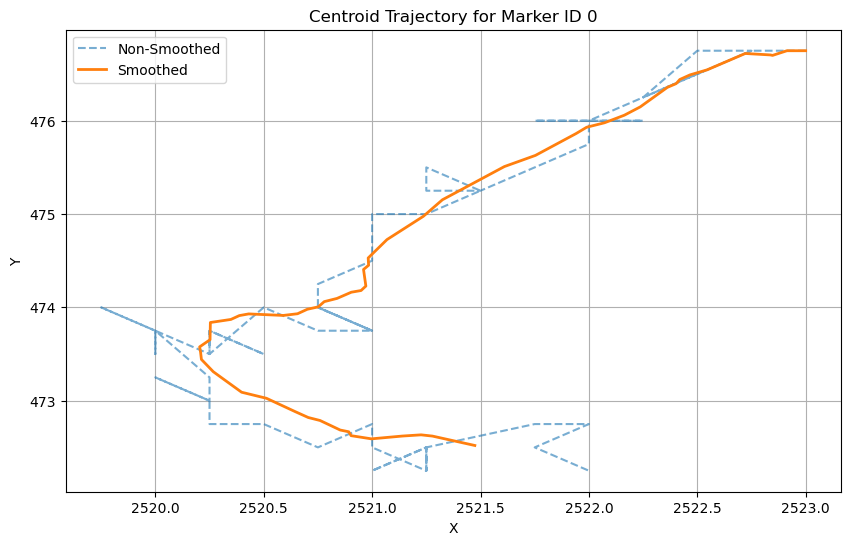

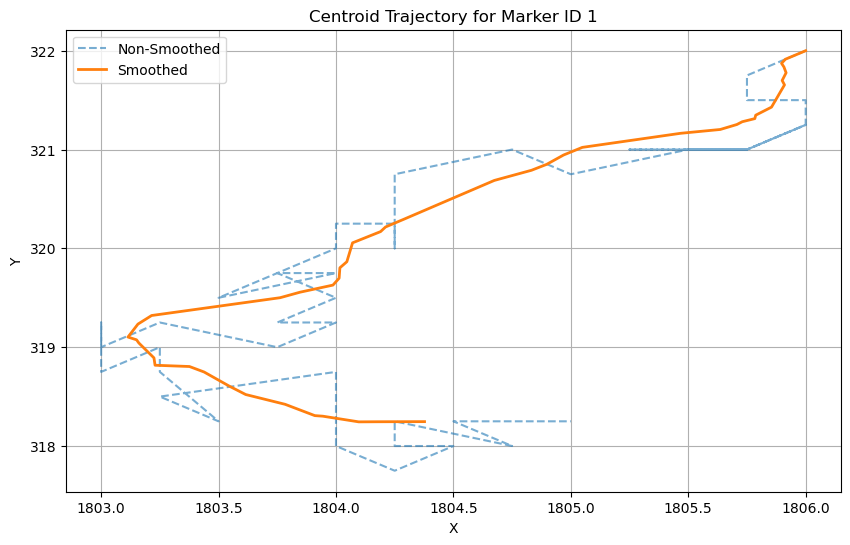

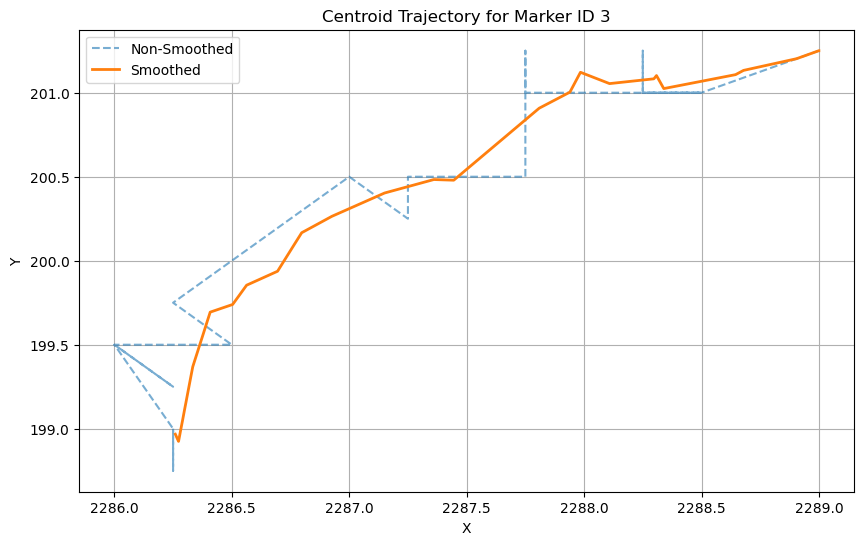

In [33]:
# Load the saved JSON data
# with open('centroids_data_moving_avg.json', 'r') as f:
    # data = json.load(f)

# non_smoothed = data['non_smoothed_centroids']
# smoothed = data['smoothed_centroids']

# IDs to plot
ids_to_plot = [0,1,3]

# Plot for each ID
for id_ in ids_to_plot:
    non_smoothed_data = np.array(unsmoothed_centroids_history[id_])
    smoothed_data = np.array(smoothed_centroids_history_full[id_])

    # Create a new figure for each ID
    plt.figure(figsize=(10, 6))
    plt.plot(non_smoothed_data[0:100:, 0], non_smoothed_data[0:100, 1], '--', label='Non-Smoothed', alpha=0.6)
    plt.plot(smoothed_data[0:100, 0], smoothed_data[0:100, 1], label='Smoothed', linewidth=2)
    
    # Add plot details
    plt.title(f"Centroid Trajectory for Marker ID {id_}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    # plt.show()

In [42]:
import cv2
import numpy as np
import collections
import json


# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered_rolling_avg.MP4'

# Frame range for processing
start_frame = 0  # Change to your desired starting frame
end_frame = 1500   # Change to your desired ending frame

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Rolling average window size
window_size = 2  # Adjust based on your smoothing preference

# Initialize rolling average buffers for marker corners
rolling_corners_history = {}


# Function to compute rolling average
def compute_rolling_average(buffer):
    return np.mean(buffer, axis=0)


# Function to detect and smooth ArUco marker corners using rolling average, then calculate centroids
def detect_and_smooth_markers_rolling_avg(frame, tile_size=1200, overlap=200):
    h, w = frame.shape[:2]
    all_corners = {}
    all_ids = []
    smoothed_centroids = {}

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            start_x = max(0, x - overlap)
            start_y = max(0, y - overlap)
            end_x = min(w, x + tile_size + overlap)
            end_y = min(h, y + tile_size + overlap)

            expanded_tile = frame[start_y:end_y, start_x:end_x]
            gray = cv2.cvtColor(expanded_tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        corner[:, :, 0] += start_x
                        corner[:, :, 1] += start_y

                        # Update rolling average buffer
                        if id_scalar not in rolling_corners_history:
                            rolling_corners_history[id_scalar] = collections.deque(maxlen=window_size)
                        rolling_corners_history[id_scalar].append(corner[0])

                        # Compute rolling average for smoothed corners
                        smoothed_corners = compute_rolling_average(np.array(rolling_corners_history[id_scalar]))

                        # Store the smoothed corners
                        all_corners[id_scalar] = smoothed_corners
                        all_ids.append(id_scalar)

    # Calculate centroids from smoothed corners
    for id_scalar, smoothed_corner in all_corners.items():
        centroid = np.mean(smoothed_corner, axis=0)
        smoothed_centroids[id_scalar] = centroid

    return smoothed_centroids, all_ids


# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Set the starting frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and initialize
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

smoothed_centroids_history = {}
first_centroids, first_ids = detect_and_smooth_markers_rolling_avg(first_frame)

if not first_ids:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

out.write(first_frame)

# Process the remaining frames
frame_count = start_frame

while cap.isOpened() and frame_count <= end_frame:
    ret, frame = cap.read()
    if not ret:
        break

    smoothed_centroids, ids = detect_and_smooth_markers_rolling_avg(frame)
    if ids and len(ids) >= 2:
        # Align the current frame to the first frame
        matched_ids = set(first_ids).intersection(set(ids))
        if len(matched_ids) >= 2:
            pts_src = np.array([smoothed_centroids[id_] for id_ in matched_ids])
            pts_dst = np.array([first_centroids[id_] for id_ in matched_ids])

            if len(matched_ids) >= 3:
                M, _ = cv2.estimateAffine2D(pts_src, pts_dst, method=cv2.RANSAC)
            else:
                M, _ = cv2.estimateAffinePartial2D(pts_src, pts_dst, method=cv2.RANSAC)

            if M is not None:
                warped_frame = cv2.warpAffine(frame, M, (width, height))
                out.write(warped_frame)
            else:
                print(f"[INFO] Frame {frame_count}: Transformation could not be computed.")
                out.write(frame)
        else:
            print(f"[INFO] Frame {frame_count}: Not enough matched markers for alignment.")
            out.write(frame)
    else:
        print(f"[INFO] Frame {frame_count}: No valid markers detected.")
        out.write(frame)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

cap.release()
out.release()

print(f"[INFO] Video processing complete. Frames {start_frame} to {end_frame} processed.")


Processed frame 0
Processed frame 100
Processed frame 200
Processed frame 300
Processed frame 400
Processed frame 500
Processed frame 600
Processed frame 700
Processed frame 800
Processed frame 900
Processed frame 1000
Processed frame 1100
Processed frame 1200
Processed frame 1300
Processed frame 1400
Processed frame 1500
[INFO] Video processing complete. Frames 0 to 1500 processed.


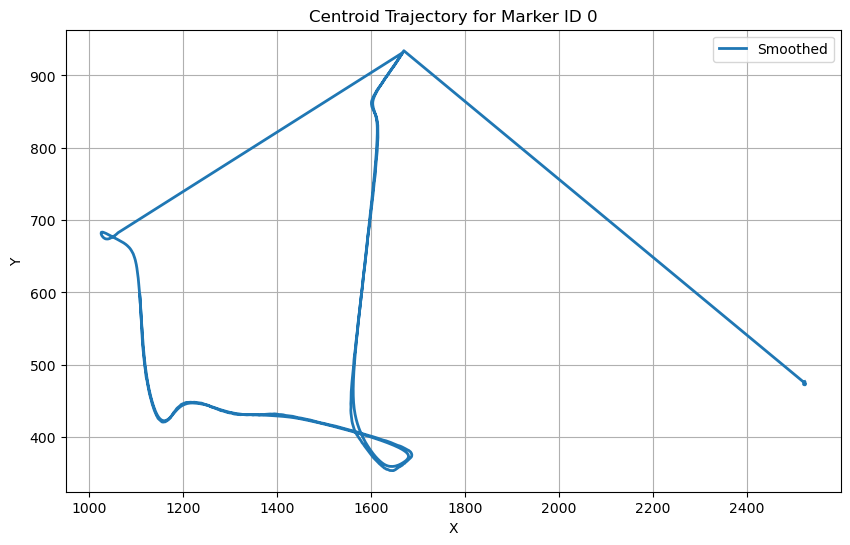

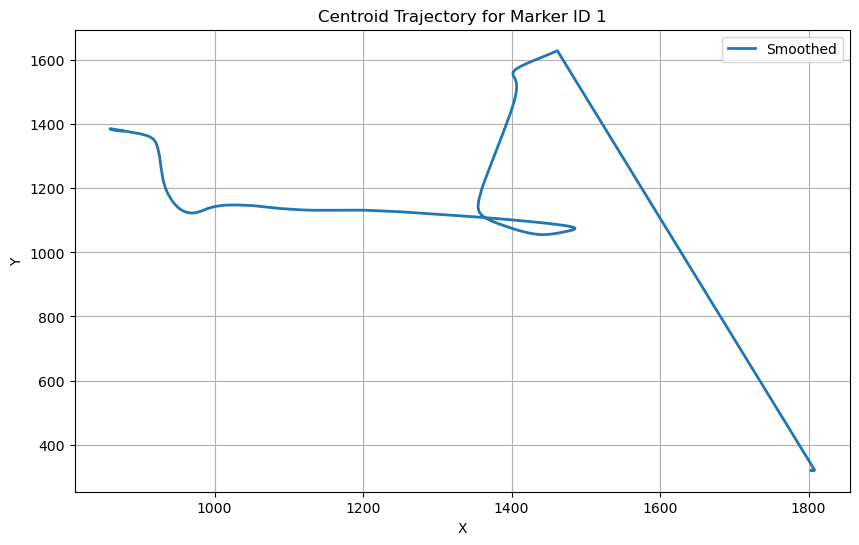

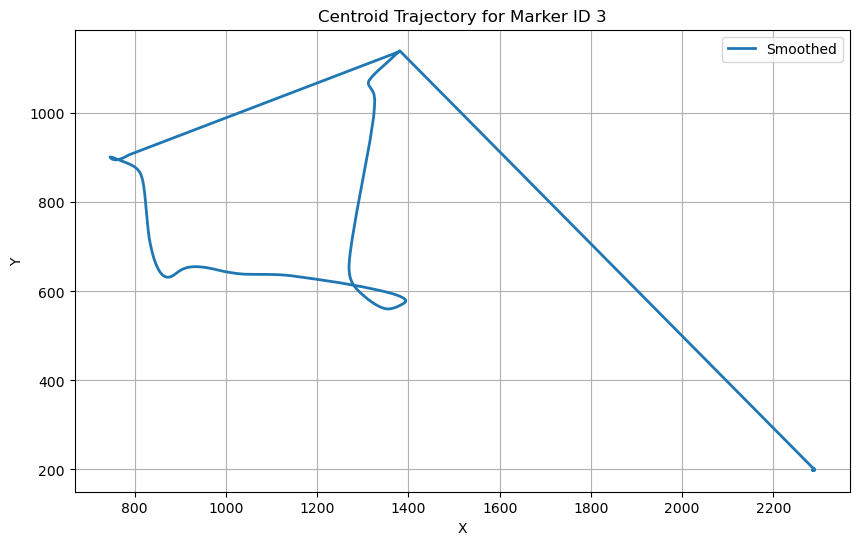

In [44]:
# Load the saved JSON data
# with open('centroids_data_moving_avg.json', 'r') as f:
    # data = json.load(f)

# non_smoothed = data['non_smoothed_centroids']
# smoothed = data['smoothed_centroids']

# IDs to plot
ids_to_plot = [0,1,3]

# Plot for each ID
for id_ in ids_to_plot:
    non_smoothed_data = np.array(unsmoothed_centroids_history[id_])
    smoothed_data = np.array(smoothed_centroids_history_full[id_])

    # Create a new figure for each ID
    plt.figure(figsize=(10, 6))
    plt.plot(non_smoothed_data[0:1500:, 0], non_smoothed_data[0:1500, 1], '--', label='Non-Smoothed', alpha=0.6)
    plt.plot(smoothed_data[0:1500, 0], smoothed_data[0:1500, 1], label='Smoothed', linewidth=2)
    
    # Add plot details
    plt.title(f"Centroid Trajectory for Marker ID {id_}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    # plt.show()

In [ ]:
import cv2
import numpy as np
import collections
import json


# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered_rolling_avg.MP4'

# Frame range for processing
start_frame = 0  # Change to your desired starting frame
end_frame = 1500   # Change to your desired ending frame

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Rolling average window size
window_size = 10  # Adjust based on your smoothing preference

# Initialize rolling average buffers for marker corners
rolling_corners_history = {}


# Function to compute rolling average
def compute_rolling_average(buffer):
    return np.mean(buffer, axis=0)


# Function to detect and smooth ArUco marker corners using rolling average, then calculate centroids
def detect_and_smooth_markers_rolling_avg(frame, tile_size=1200, overlap=200):
    h, w = frame.shape[:2]
    all_corners = {}
    all_ids = []
    smoothed_centroids = {}

    # Overlay for tile visualization
    visualization_frame = frame.copy()

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            start_x = max(0, x - overlap)
            start_y = max(0, y - overlap)
            end_x = min(w, x + tile_size + overlap)
            end_y = min(h, y + tile_size + overlap)

            # Draw tile rectangles
            cv2.rectangle(visualization_frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

            expanded_tile = frame[start_y:end_y, start_x:end_x]
            gray = cv2.cvtColor(expanded_tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        corner[:, :, 0] += start_x
                        corner[:, :, 1] += start_y

                        # Draw detected markers
                        cv2.polylines(visualization_frame, [corner.astype(int)], True, (255, 0, 0), 2)
                        cv2.putText(visualization_frame, str(id_scalar),
                                    tuple(corner[0, 0].astype(int)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

                        # Update rolling average buffer
                        if id_scalar not in rolling_corners_history:
                            rolling_corners_history[id_scalar] = collections.deque(maxlen=window_size)
                        rolling_corners_history[id_scalar].append(corner[0])

                        # Compute rolling average for smoothed corners
                        smoothed_corners = compute_rolling_average(np.array(rolling_corners_history[id_scalar]))

                        # Store the smoothed corners
                        all_corners[id_scalar] = smoothed_corners
                        all_ids.append(id_scalar)

    # Calculate centroids from smoothed corners
    for id_scalar, smoothed_corner in all_corners.items():
        centroid = np.mean(smoothed_corner, axis=0)
        smoothed_centroids[id_scalar] = centroid

    return visualization_frame, smoothed_centroids, all_ids


# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Set the starting frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and initialize
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

smoothed_centroids_history = {}
visualized_frame, first_centroids, first_ids = detect_and_smooth_markers_rolling_avg(first_frame)

if not first_ids:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

out.write(visualized_frame)

# Process the remaining frames
frame_count = start_frame

while cap.isOpened() and frame_count <= end_frame:
    ret, frame = cap.read()
    if not ret:
        break

    visualized_frame, smoothed_centroids, ids = detect_and_smooth_markers_rolling_avg(frame)
    if ids and len(ids) >= 2:
        # Align the current frame to the first frame
        matched_ids = set(first_ids).intersection(set(ids))
        if len(matched_ids) >= 2:
            pts_src = np.array([smoothed_centroids[id_] for id_ in matched_ids])
            pts_dst = np.array([first_centroids[id_] for id_ in matched_ids])

            if len(matched_ids) >= 3:
                M, _ = cv2.estimateAffine2D(pts_src, pts_dst, method=cv2.RANSAC)
            else:
                M, _ = cv2.estimateAffinePartial2D(pts_src, pts_dst, method=cv2.RANSAC)

            if M is not None:
                warped_frame = cv2.warpAffine(frame, M, (width, height))
                out.write(warped_frame)
            else:
                print(f"[INFO] Frame {frame_count}: Transformation could not be computed.")
                out.write(visualized_frame)
        else:
            print(f"[INFO] Frame {frame_count}: Not enough matched markers for alignment.")
            out.write(visualized_frame)
    else:
        print(f"[INFO] Frame {frame_count}: No valid markers detected.")
        out.write(visualized_frame)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

cap.release()
out.release()

print(f"[INFO] Video processing complete. Frames {start_frame} to {end_frame} processed.")


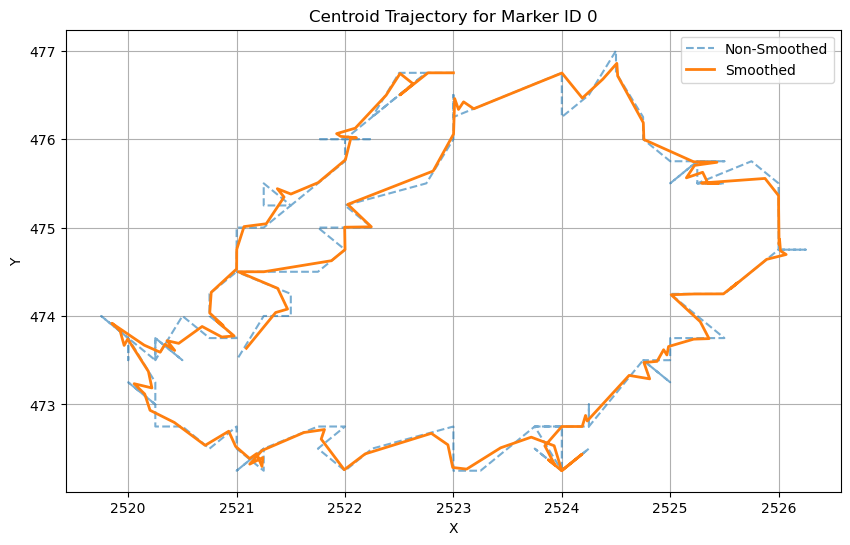

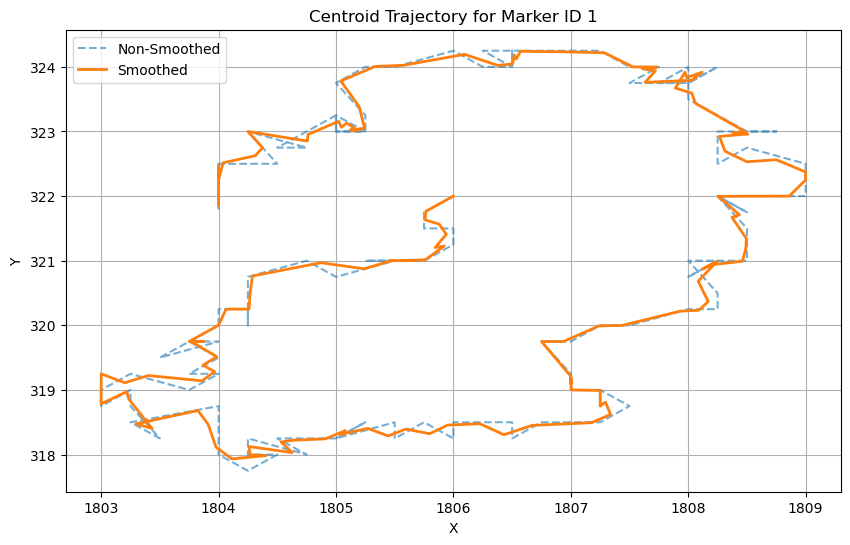

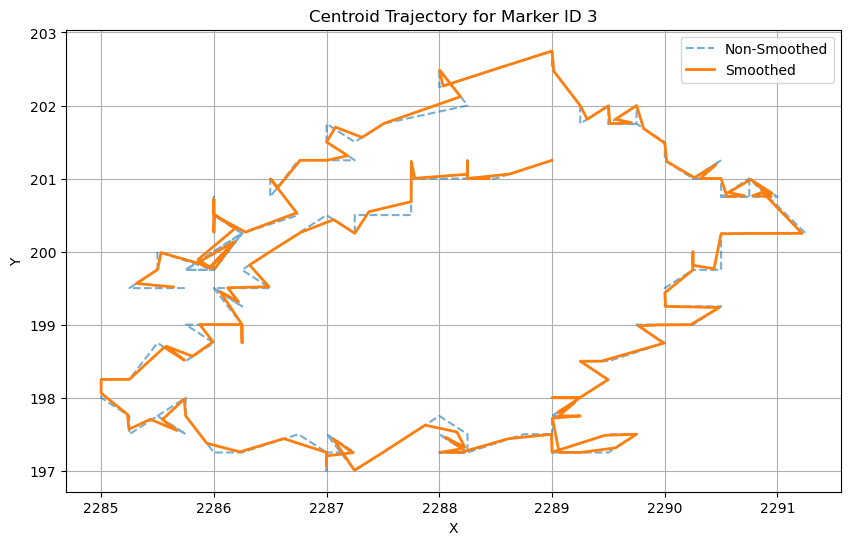

In [16]:
# Load the saved JSON data
# with open('centroids_data_moving_avg.json', 'r') as f:
    # data = json.load(f)

# non_smoothed = data['non_smoothed_centroids']
# smoothed = data['smoothed_centroids']

# IDs to plot
ids_to_plot = [0,1,3]

# Plot for each ID
for id_ in ids_to_plot:
    non_smoothed_data = np.array(unsmoothed_centroids_history[id_])
    smoothed_data = np.array(smoothed_centroids_history_full[id_])

    # Create a new figure for each ID
    plt.figure(figsize=(10, 6))
    plt.plot(non_smoothed_data[:, 0], non_smoothed_data[:, 1], '--', label='Non-Smoothed', alpha=0.6)
    plt.plot(smoothed_data[:, 0], smoothed_data[:, 1], label='Smoothed', linewidth=2)
    
    # Add plot details
    plt.title(f"Centroid Trajectory for Marker ID {id_}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.show()

Processed frame 0
Processed frame 100
Processed frame 200


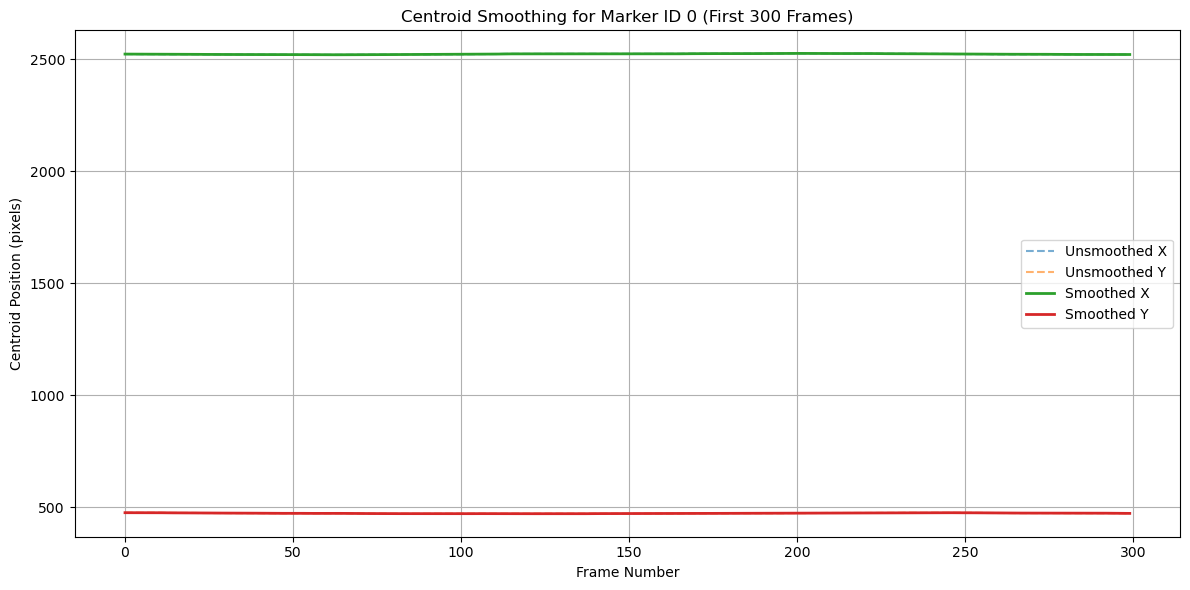

[INFO] Centroids data and video processing complete.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json


# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered_ema.MP4'

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Smoothing factor for exponential moving average
alpha = 0.5  # Adjust between 0 and 1; lower values mean more smoothing

# Initialize smoothed centroids history
smoothed_centroids_history = {}

# Function to detect ArUco markers in image tiles and compute centroids
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=200):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []
    centroids = {}

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            start_x = max(0, x - overlap)
            start_y = max(0, y - overlap)
            end_x = min(w, x + tile_size + overlap)
            end_y = min(h, y + tile_size + overlap)
            cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)  # Expanded region
            cv2.rectangle(frame, (x, y), (x + tile_size, y + tile_size), (255, 0, 0), 2)  # Original tile

            expanded_tile = frame[start_y:end_y, start_x:end_x]
            gray = cv2.cvtColor(expanded_tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        corner[:, :, 0] += start_x
                        corner[:, :, 1] += start_y

                        detected_corners.append(corner)
                        detected_ids.append(id_scalar)

                        centroid = np.mean(corner[0], axis=0)
                        centroids[id_scalar] = centroid

    if detected_ids:
        detected_ids = np.array(detected_ids)
        cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
    else:
        detected_ids = None

    return frame, centroids, detected_ids


# Function to plot unsmoothed vs. smoothed centroids
def plot_centroid_smoothing(marker_id, unsmoothed, smoothed, num_frames=500):
    num_frames = min(num_frames, len(unsmoothed), len(smoothed))
    if num_frames > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(range(num_frames), unsmoothed[:num_frames, 0], label="Unsmoothed X", alpha=0.6, linestyle="--")
        plt.plot(range(num_frames), unsmoothed[:num_frames, 1], label="Unsmoothed Y", alpha=0.6, linestyle="--")
        plt.plot(range(num_frames), smoothed[:num_frames, 0], label="Smoothed X", linewidth=2)
        plt.plot(range(num_frames), smoothed[:num_frames, 1], label="Smoothed Y", linewidth=2)
        plt.title(f"Centroid Smoothing for Marker ID {marker_id} (First {num_frames} Frames)")
        plt.xlabel("Frame Number")
        plt.ylabel("Centroid Position (pixels)")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
    else:
        print(f"[INFO] Not enough data available for Marker ID {marker_id}.")


# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

first_frame_detected, first_centroids, first_ids = detect_aruco_markers_in_tiles(first_frame)
if first_ids is None or len(first_ids) < 2:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

# Initialize smoothed centroids with the first frame's centroids
for id_, centroid in first_centroids.items():
    smoothed_centroids_history[id_] = centroid.copy()

# Write the first frame to the output video
out.write(first_frame_detected)

# Initialize variables for smoothing and tracking
unsmoothed_centroids_history = {}
smoothed_centroids_history_full = {}
frame_count = 0
max_frames = 300  # Limit processing to the first 1500 frames

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    detected_frame, centroids, ids = detect_aruco_markers_in_tiles(frame)
    if ids is not None:
        for id_ in ids:
            centroid = centroids[id_]
            if id_ not in unsmoothed_centroids_history:
                unsmoothed_centroids_history[id_] = []
            unsmoothed_centroids_history[id_].append(centroid.tolist())

            if id_ in smoothed_centroids_history:
                smoothed_centroid = alpha * centroid + (1 - alpha) * smoothed_centroids_history[id_]
                smoothed_centroids_history[id_] = smoothed_centroid.copy()
            else:
                smoothed_centroid = centroid.copy()
                smoothed_centroids_history[id_] = smoothed_centroid.copy()

            if id_ not in smoothed_centroids_history_full:
                smoothed_centroids_history_full[id_] = []
            smoothed_centroids_history_full[id_].append(smoothed_centroid.tolist())
    else:
        print(f"[INFO] Frame {frame_count}: No valid markers detected.")

    out.write(detected_frame)
    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

cap.release()
out.release()

# Save centroids data to JSON
output_data = {
    "non_smoothed_centroids": {str(k): np.array(v).tolist() for k, v in unsmoothed_centroids_history.items()},
    "smoothed_centroids": {str(k): np.array(v).tolist() for k, v in smoothed_centroids_history_full.items()},
}
with open('centroids_data_moving_ema.json', 'w') as f:
    json.dump(output_data, f)

# Example: Plot for marker ID 0
example_marker_id = "0"
unsmoothed = np.array(output_data["non_smoothed_centroids"].get(example_marker_id, []))
smoothed = np.array(output_data["smoothed_centroids"].get(example_marker_id, []))
plot_centroid_smoothing(example_marker_id, unsmoothed, smoothed)

print("[INFO] Centroids data and video processing complete.")


In [3]:

# Define the path to the input video and the ArUCo type
# video_path = '/media/maldives/2024_data/20240303/drone1/drone_videos/20240303_072831125_DJI_0266.MP4'
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'

# video_path = 'E:/sophia/files/videofiles/20240305_065328211_DJI_0260.MP4'
output_h5_path = "/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.h5"  # Path to save the marker data
output_video_path = "/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_aruco.MP4"  # Update with the desired output path

# Load the ArUCo dictionary 
# ARUCO_DICT = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_250)
aruco_type = cv2.aruco.DICT_4X4_50

# Load the ArUCo dictionary
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
# ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
# ARUCO_DICT.bytesList = ARUCO_DICT.bytesList[0,1,2]

# aruco_params = aruco.DetectorParameters_create()

ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()
# Function to detect ArUco markers in image tiles
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=0):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []
    marker_positions = []
    orientations = []

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            # Adjust tile size for boundary tiles
            tile_w = min(tile_size, w - x)
            tile_h = min(tile_size, h - y)
            tile = frame[y:y + tile_h, x:x + tile_w]

            gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
            corners, ids, rejected = cv2.aruco.detectMarkers(gray, ARUCO_DICT)

            if ids is not None:
                for corner, id in zip(corners, ids):
                    # Adjust corner coordinates to the original image
                    corner[:, :, 0] += x
                    corner[:, :, 1] += y

                    detected_corners.append(corner)
                    detected_ids.append(id)
                    marker_positions.append(corner)

    if detected_ids:
        detected_ids = np.array(detected_ids)
        # Draw detected markers on the frame
        cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
        
        for i, corner in enumerate(detected_corners):
            (top_left, top_right, bottom_right, bottom_left) = corner[0]
            vector_1 = top_right - top_left
            vector_2 = bottom_right - top_right
            angle_1 = np.arctan2(vector_1[1], vector_1[0]) * 180 / np.pi
            angle_2 = np.arctan2(vector_2[1], vector_2[0]) * 180 / np.pi
            orientation = (angle_1 + angle_2) / 2

            # Calculate the centroid of the marker
            centroid_x = int((top_left[0] + top_right[0] + bottom_right[0] + bottom_left[0]) / 4)
            centroid_y = int((top_left[1] + top_right[1] + bottom_right[1] + bottom_left[1]) / 4)
            centroid = (centroid_x, centroid_y)
            
           

            text = f"ID: {detected_ids[i][0]}, Orientation: {orientation:.2f}"
            # print(text)
            position = tuple(top_left.astype(int))
            # Offset the text slightly below the marker to avoid overlap
            text_position = (position[0] + 15, position[1] + 15)
            # Write text on video frame
            cv2.putText(frame, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (50, 255, 255), 2)

            orientations.append((detected_ids[i][0], orientation, centroid_x, centroid_y, 
                                 top_left[0], top_left[1], top_right[0], top_right[1], 
                                 bottom_right[0], bottom_right[1], bottom_left[0], bottom_left[1]
                                ))

    return frame, orientations

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Dataframe to store the marker data with explicit data types
df = pd.DataFrame(columns=["frame", "ID", "orientation", "centroid_x", "centroid_y", 
                           "top_left_x", "top_left_y", "top_right_x", "top_right_y",
                           "bottom_right_x", "bottom_right_y", "bottom_left_x", "bottom_left_y"])
df = df.astype({"frame": int, "ID": int, "orientation": float, "centroid_x": int, "centroid_y": int, 
                "top_left_x": int, "top_left_y": int, "top_right_x": int, "top_right_y": int,
                "bottom_right_x": int, "bottom_right_y": int, "bottom_left_x": int, "bottom_left_y": int})

frame_count = 0

# Process the first 1000 frames and save the video
while cap.isOpened() and frame_count < 100:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect ArUco markers in the current frame
    detected_frame, orientations = detect_aruco_markers_in_tiles(frame)

    # Create a temporary dataframe to hold the current frame's data
    if orientations:
        temp_df = pd.DataFrame(orientations, columns=["ID", "orientation", "centroid_x", "centroid_y", 
                                                      "top_left_x", "top_left_y", "top_right_x", "top_right_y",
                                                      "bottom_right_x", "bottom_right_y", "bottom_left_x", "bottom_left_y"])
        temp_df["frame"] = frame_count
        temp_df = temp_df.astype({"frame": int, "ID": int, "orientation": float, "centroid_x": int, "centroid_y": int, 
                                  "top_left_x": int, "top_left_y": int, "top_right_x": int, "top_right_y": int,
                                  "bottom_right_x": int, "bottom_right_y": int, "bottom_left_x": int, "bottom_left_y": int})

        # Concatenate the temporary dataframe with the main dataframe
        df = pd.concat([df, temp_df], ignore_index=True)

    # Write the annotated frame to the output video
    out.write(detected_frame)

    if frame_count % 100 == 0:
        # break
        print(f"Processed frame {frame_count}")

    frame_count += 1

# Release the video writer after the first 1000 frames
out.release()

# Continue processing the rest of the video to save marker data
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # print(frame)
    # Detect ArUco markers in the current frame
    detected_frame, orientations = detect_aruco_markers_in_tiles(frame)

    # Create a temporary dataframe to hold the current frame's data
    if orientations:
        temp_df = pd.DataFrame(orientations, columns=["ID", "orientation", "centroid_x", "centroid_y", 
                                                      "top_left_x", "top_left_y", "top_right_x", "top_right_y",
                                                      "bottom_right_x", "bottom_right_y", "bottom_left_x", "bottom_left_y"])
        temp_df["frame"] = frame_count
        temp_df = temp_df.astype({"frame": int, "ID": int, "orientation": float, "centroid_x": int, "centroid_y": int, 
                                  "top_left_x": int, "top_left_y": int, "top_right_x": int, "top_right_y": int,
                                  "bottom_right_x": int, "bottom_right_y": int, "bottom_left_x": int, "bottom_left_y": int})

        # Concatenate the temporary dataframe with the main dataframe
        df = pd.concat([df, temp_df], ignore_index=True)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

# Save the dataframe to an HDF5 file to your folder defined in output_h5_path
# df.to_hdf(output_h5_path, key='df', mode='w')
# print("[INFO] Data saved to HDF5 file.")

# Release video objects
cap.release()
print("[INFO] Video processing complete.")

Processed frame 0


KeyboardInterrupt: 

### Clean dataframe

In [4]:
###I should have only IDs 0,1,3 so i can throw away data from any other ID
df_filter = df.copy()

In [21]:
df_filter = df_filter[df_filter['ID'].isin([0,1,3])].reset_index(drop = True)

In [22]:
df_filter.head()

,index,frame,ID,orientation,centroid_x,centroid_y,top_left_x,top_left_y,top_right_x,top_right_y,...,centroid_x_savgol,centroid_y_savgol,top_left_x_savgol,top_left_y_savgol,top_right_x_savgol,top_right_y_savgol,bottom_right_x_savgol,bottom_right_y_savgol,bottom_left_x_savgol,bottom_left_y_savgol
0,0,0,3,-125.266400,2289,201,2302,220,2271,215,...,2142.6,304.4,2144.6,314.8,2132.8,306.2,2141.4,294.4,2151.6,303.2
1,1,0,1,-30.288202,1806,322,1788,333,1795,302,...,2231.1,520.2,2235.4,528.4,2222.4,524.7,2227.6,512.6,2239.3,516.1
2,2,0,0,-24.227746,2523,476,2543,468,2532,497,...,2319.6,736.0,2326.2,742.0,2312.0,743.2,2313.8,730.8,2327.0,729.0
3,4,1,3,-125.266400,2289,201,2302,220,2271,215,...,2366.4,791.0,2374.4,791.6,2364.2,799.6,2359.0,791.6,2368.6,782.6
4,5,1,1,-30.288202,1806,322,1788,333,1795,302,...,2319.4,736.0,2326.0,742.0,2311.8,743.0,2313.8,730.8,2327.0,729.0


In [4]:
# aruco_dict = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
# aruco_dict.bytesList = aruco_dict.bytesList[0,1,2]

# aruco_params = aruco.DetectorParameters_create()

In [7]:
df1 = df.groupby('ID').get_group(1)

In [8]:
cols_to_smooth = df1.columns[3:13]

In [9]:
df_moving_avg = df1[cols_to_smooth].rolling(window=2).mean()

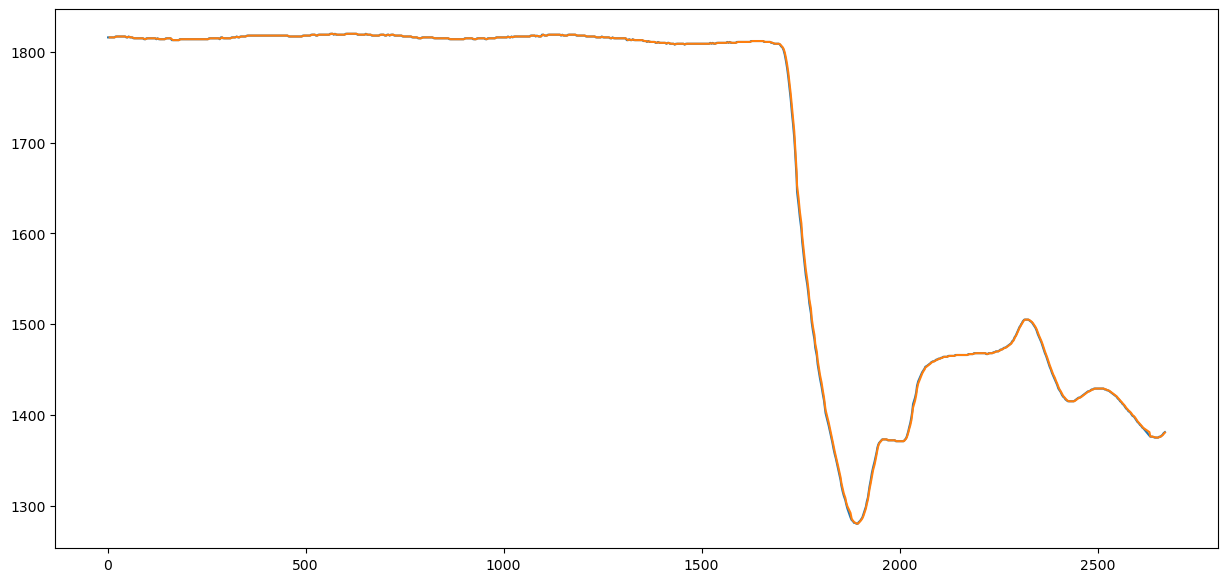

In [10]:
plt.subplots(1,1,figsize=(15,7))
plt.plot(df1['bottom_left_x'][0:900])
plt.plot(df_moving_avg['bottom_left_x'][0:900])

In [23]:
from scipy.signal import savgol_filter
for column in cols_to_smooth:
    df[f'{column}_savgol'] = savgol_filter(df[column], window_length=5, polyorder=1)


### Example plot

In [12]:
import random

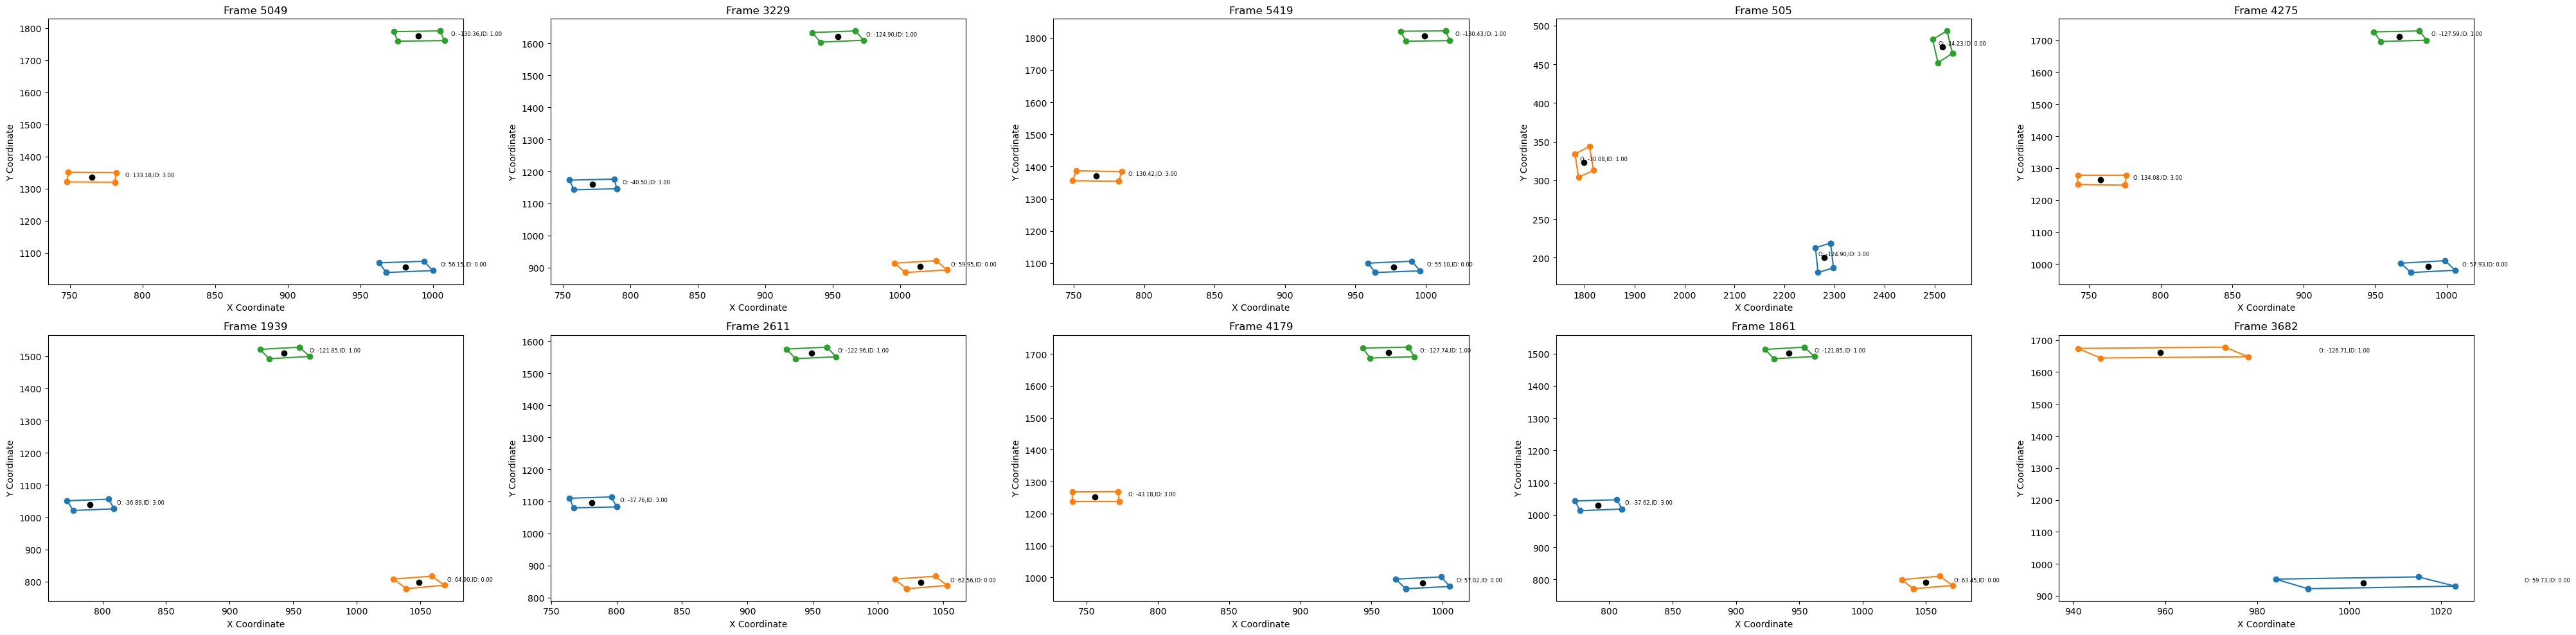

In [24]:
# Select 10 random frames
unique_frames = df_filter['frame'].unique()
random_frames = random.sample(list(unique_frames), 10)

# Create a 2x5 subplot
fig, axes = plt.subplots(2, 5, figsize=(40, 10))
axes = axes.flatten()

# Plot the points for each random frame
for ax, frame in zip(axes, random_frames):
    frame_data = df[df['frame'] == frame]
    
    for _, row in frame_data.iterrows():
        x_points = [row['top_left_x'], row['top_right_x'], row['bottom_right_x'], row['bottom_left_x'], row['top_left_x']]
        y_points = [row['top_left_y'], row['top_right_y'], row['bottom_right_y'], row['bottom_left_y'], row['top_left_y']]
        

        ax.plot(x_points, y_points, marker='o')
        ax.plot(row['centroid_x'], row['centroid_y'], marker='o',color='k')
        # Annotate with orientation
        ax.text(row['centroid_x']+40, row['centroid_y']+3, f"O: {row['orientation']:.2f},ID: {row['ID']:.2f}", fontsize=6, ha='center')

    ax.set_title(f'Frame {frame}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
# Adjust layout
plt.tight_layout()
plt.show()


### Homography

In [9]:
import cv2
import numpy as np
import pandas as pd

# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = "/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered.MP4"  # Update with the desired output path

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Function to detect ArUco markers in image tiles (using your detection method)
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=0):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            # Adjust tile size for boundary tiles
            tile_w = min(tile_size, w - x)
            tile_h = min(tile_size, h - y)
            tile = frame[y:y + tile_h, x:x + tile_w]

            gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
            corners, ids, rejected = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id in zip(corners, ids):
                    id_scalar = id[0]  # Extract scalar ID
                    if id_scalar in VALID_IDS:
                        # Adjust corner coordinates to the original image
                        corner[:, :, 0] += x
                        corner[:, :, 1] += y

                        detected_corners.append(corner)
                        detected_ids.append(id_scalar)
                    else:
                        print(f"[WARNING] Detection error: Marker ID {id_scalar} is not in {VALID_IDS}.")

    if detected_ids:
        detected_ids = np.array(detected_ids)
        # Draw detected markers on the frame
        cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
    else:
        detected_ids = None

    return frame, detected_corners, detected_ids

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, prev_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

prev_frame_detected, prev_corners, prev_ids = detect_aruco_markers_in_tiles(prev_frame)
if prev_ids is None or len(prev_ids) < 2:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

# Create a dictionary of marker IDs and their corresponding corner points for the previous frame
prev_corners_dict = {id_: corner for id_, corner in zip(prev_ids, prev_corners)}

# Initialize cumulative homography as identity matrix
cumulative_H = np.eye(3)

# Write the first frame to the output video
out.write(prev_frame)

frame_count = 1

# Limit processing to the first 500 frames
max_frames = 500

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    detected_frame, corners, ids = detect_aruco_markers_in_tiles(frame)
    if ids is not None and len(ids) >= 2:
        # Create a dictionary of current frame markers
        corners_dict = {id_: corner for id_, corner in zip(ids, corners)}

        matched_ids = set(ids).intersection(set(prev_ids))
        if len(matched_ids) >= 2:
            pts_prev = []
            pts_current = []
            for id_ in matched_ids:
                # Use all four corners of the marker
                pts_prev.extend(prev_corners_dict[id_][0])
                pts_current.extend(corners_dict[id_][0])

            pts_prev = np.array(pts_prev)
            pts_current = np.array(pts_current)

            # Compute homography between previous frame and current frame
            H, mask = cv2.findHomography(pts_current, pts_prev, cv2.RANSAC)

            if H is not None:
                # Update cumulative homography
                cumulative_H = cumulative_H @ H

                # Warp the current frame using the cumulative homography
                warped_frame = cv2.warpPerspective(frame, cumulative_H, (width, height))

                out.write(warped_frame)
            else:
                print(f"[INFO] Frame {frame_count}: Homography could not be computed. Using previous homography.")
                # Use previous cumulative homography
                warped_frame = cv2.warpPerspective(frame, cumulative_H, (width, height))
                out.write(warped_frame)
        else:
            print(f"[INFO] Frame {frame_count}: Not enough matched markers. Using previous homography.")
            # Use previous cumulative homography
            warped_frame = cv2.warpPerspective(frame, cumulative_H, (width, height))
            out.write(warped_frame)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough valid markers detected. Using previous homography.")
        # Use previous cumulative homography
        warped_frame = cv2.warpPerspective(frame, cumulative_H, (width, height))
        out.write(warped_frame)

    # Update previous frame data
    prev_frame = frame.copy()
    prev_corners_dict = corners_dict.copy() if ids is not None else prev_corners_dict
    prev_ids = ids.copy() if ids is not None else prev_ids

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

# Release video objects
cap.release()
out.release()
print("[INFO] Video processing complete.")


[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 100
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 200
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 300
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error

### smoothing

In [17]:
import cv2
import numpy as np
import pandas as pd

# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = "/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered.MP4"  # Update with the desired output path

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Smoothing factor for exponential moving average
alpha = 1  # Adjust this between 0 and 1; lower values mean more smoothing

# Initialize smoothed corners history
smoothed_corners_history = {}

# Function to detect ArUco markers in image tiles (using your detection method)
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=0):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            # Adjust tile size for boundary tiles
            tile_w = min(tile_size, w - x)
            tile_h = min(tile_size, h - y)
            tile = frame[y:y + tile_h, x:x + tile_w]

            gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
            corners, ids, rejected = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id in zip(corners, ids):
                    id_scalar = id[0]  # Extract scalar ID
                    if id_scalar in VALID_IDS:
                        # Adjust corner coordinates to the original image
                        corner[:, :, 0] += x
                        corner[:, :, 1] += y

                        detected_corners.append(corner)
                        detected_ids.append(id_scalar)
                    else:
                        print(f"[WARNING] Detection error: Marker ID {id_scalar} is not in {VALID_IDS}.")

    if detected_ids:
        detected_ids = np.array(detected_ids)
        # Draw detected markers on the frame
        cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
    else:
        detected_ids = None

    return frame, detected_corners, detected_ids

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

first_frame_detected, first_corners, first_ids = detect_aruco_markers_in_tiles(first_frame)
if first_ids is None or len(first_ids) < 2:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

# Initialize smoothed corners with the first frame's corners
for id_, corner in zip(first_ids, first_corners):
    smoothed_corners_history[id_] = corner.copy()

# Create a dictionary of marker IDs and their corresponding corner points in the first frame
first_corners_dict = {id_: corner for id_, corner in zip(first_ids, first_corners)}

# Collect all corner points from the first frame
pts_dst = []
for id_ in first_ids:
    pts_dst.extend(first_corners_dict[id_][0])

pts_dst = np.array(pts_dst)

# Write the first frame to the output video
out.write(first_frame_detected)

frame_count = 1

# Limit processing to the first 500 frames
max_frames = 500

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    detected_frame, corners, ids = detect_aruco_markers_in_tiles(frame)
    if ids is not None and len(ids) >= 2:
        # Apply smoothing to the detected corners
        smoothed_corners = []
        for id_, corner in zip(ids, corners):
            if id_ in smoothed_corners_history:
                # Exponential Moving Average (EMA)
                smoothed_corner = alpha * corner + (1 - alpha) * smoothed_corners_history[id_]
                smoothed_corners_history[id_] = smoothed_corner.copy()
            else:
                # Initialize if not present
                smoothed_corner = corner.copy()
                smoothed_corners_history[id_] = corner.copy()
            smoothed_corners.append(smoothed_corner)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough valid markers detected.")
        out.write(frame)
        frame_count += 1
        continue  # Skip to the next frame

    # Create a dictionary of marker IDs and their smoothed corners in the current frame
    corners_dict = {id_: corner for id_, corner in zip(ids, smoothed_corners)}

    # Find common markers between current frame and the first frame
    matched_ids = set(first_ids).intersection(set(ids))

    if len(matched_ids) >= 2:
        # Use all corners of matched markers for homography estimation
        pts_src = []
        pts_dst_matched = []
        for id_ in matched_ids:
            pts_src.extend(corners_dict[id_][0])
            pts_dst_matched.extend(first_corners_dict[id_][0])

        pts_src = np.array(pts_src)
        pts_dst_matched = np.array(pts_dst_matched)

        # Compute homography between current frame and first frame
        H, mask = cv2.findHomography(pts_src, pts_dst_matched, cv2.RANSAC)

        if H is not None:
            # Warp the current frame to align with the first frame
            warped_frame = cv2.warpPerspective(frame, H, (width, height))

            out.write(warped_frame)
        else:
            print(f"[INFO] Frame {frame_count}: Homography could not be computed.")
            out.write(frame)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough matched markers.")
        out.write(frame)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

# Release video objects
cap.release()
out.release()
print("[INFO] Video processing complete.")


[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 100
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 200
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 300
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error

### Distances

In [ ]:
### Try guessing angle of missing triangle angle based on other 2

[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 0
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 100
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 200
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: 

In [21]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import numpy as np
# import json


# # Define the path to the input video and the ArUCo type
# video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
# output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered_ema.MP4'

# # Load the ArUCo dictionary
# aruco_type = cv2.aruco.DICT_4X4_50
# ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
# ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# # Specify the valid marker IDs
# VALID_IDS = [0, 1, 3]

# # Smoothing factor for exponential moving average
# alpha = 0.5  # Adjust between 0 and 1; lower values mean more smoothing

# # Initialize smoothed centroids history
# smoothed_centroids_history = {}

# ### Try overlapping tiles or offset tile when only 2 are found (this first)
# # Function to detect ArUco markers in image tiles and compute centroids
# def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=0):
#     h, w = frame.shape[:2]
#     detected_corners = []
#     detected_ids = []
#     centroids = {}

#     for y in range(0, h, tile_size - overlap):
#         for x in range(0, w, tile_size - overlap):
#             # Adjust tile size for boundary tiles
#             tile_w = min(tile_size, w - x)
#             tile_h = min(tile_size, h - y)
#             tile = frame[y:y + tile_h, x:x + tile_w]

#             gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
#             corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

#             if ids is not None:
#                 for corner, id_ in zip(corners, ids):
#                     id_scalar = id_[0]
#                     if id_scalar in VALID_IDS:
#                         # Adjust corner coordinates to the original image
#                         corner[:, :, 0] += x
#                         corner[:, :, 1] += y

#                         detected_corners.append(corner)
#                         detected_ids.append(id_scalar)

#                         # Compute centroid
#                         centroid = np.mean(corner[0], axis=0)
#                         centroids[id_scalar] = centroid
#                     else:
#                         print(f"[WARNING] Detection error: Marker ID {id_scalar} is not in {VALID_IDS}.")

#     if detected_ids:
#         detected_ids = np.array(detected_ids)
#         # Draw detected markers on the frame
#         cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
#     else:
#         detected_ids = None

#     return frame, centroids, detected_ids

# # Open the input video
# cap = cv2.VideoCapture(video_path)
# if not cap.isOpened():
#     print("[ERROR] Unable to open video file.")
#     exit()

# # Get video properties
# fps = cap.get(cv2.CAP_PROP_FPS)
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# # Read the first frame and detect markers
# ret, first_frame = cap.read()
# if not ret:
#     print("[ERROR] Unable to read the first frame.")
#     cap.release()
#     out.release()
#     exit()

# first_frame_detected, first_centroids, first_ids = detect_aruco_markers_in_tiles(first_frame)
# if first_ids is None or len(first_ids) < 2:
#     print("[ERROR] Not enough valid markers detected in the first frame.")
#     cap.release()
#     out.release()
#     exit()

# # Initialize smoothed centroids with the first frame's centroids
# for id_, centroid in first_centroids.items():
#     smoothed_centroids_history[id_] = centroid.copy()

# # Write the first frame to the output video
# out.write(first_frame_detected)

# # Initialize previous valid transformation
# prev_frame_index = 0
# prev_transformation = None
# prev_matched_ids = first_ids.copy()
# prev_smoothed_centroids = first_centroids.copy()

# # Buffer to store frames needing interpolation
# buffered_frames = []
# buffered_indices = []

# frame_count = 0
# max_frames = 1500  # Limit processing to the first 500 frames

# unsmoothed_centroids_history = {}
# smoothed_centroids_history_full = {}

# while cap.isOpened() and frame_count < max_frames:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     detected_frame, centroids, ids = detect_aruco_markers_in_tiles(frame)
#     if ids is not None and len(ids) >= 2:
#         smoothed_centroids = {}
#         for id_ in ids:
#             centroid = centroids[id_]
    
#             # Initialize history for unsmoothed centroids if not present
#             if id_ not in unsmoothed_centroids_history:
#                 unsmoothed_centroids_history[id_] = []
#             unsmoothed_centroids_history[id_].append(centroid.tolist())
    
#             # Apply exponential smoothing for smoothed centroids
#             if id_ in smoothed_centroids_history:
#                 smoothed_centroid = alpha * centroid + (1 - alpha) * smoothed_centroids_history[id_]
#                 smoothed_centroids_history[id_] = smoothed_centroid.copy()
#             else:
#                 smoothed_centroid = centroid.copy()
#                 smoothed_centroids_history[id_] = smoothed_centroid.copy()
    
#             # Initialize history for smoothed centroids if not present
#             if id_ not in smoothed_centroids_history_full:
#                 smoothed_centroids_history_full[id_] = []
#             smoothed_centroids_history_full[id_].append(smoothed_centroid.tolist())
    
#             # Store smoothed centroids for the current frame
#             smoothed_centroids[id_] = smoothed_centroid
        
#     else:
#         smoothed_centroids = {}
#         print(f"[INFO] Frame {frame_count}: Not enough valid markers detected.")

#     # Find common markers between current frame and the first frame
#     matched_ids = set(first_ids).intersection(set(ids)) if ids is not None else set()
#     if len(matched_ids) >= 2:
#         # Use centroids of matched markers for transformation estimation
#         pts_src = []
#         pts_dst = []
#         for id_ in matched_ids:
#             pts_src.append(smoothed_centroids[id_])
#             pts_dst.append(first_centroids[id_])

#         pts_src = np.array(pts_src)
#         pts_dst = np.array(pts_dst)

#         if len(matched_ids) >= 3:
#             # Compute affine transformation
#             M, inliers = cv2.estimateAffine2D(pts_src, pts_dst, method=cv2.RANSAC)
#         else:
#             # Compute similarity transformation
            
#             M, inliers = cv2.estimateAffinePartial2D(pts_src, pts_dst, method=cv2.RANSAC)

#         if M is not None:
#             # We have a valid transformation
#             # If we have buffered frames, interpolate transformations
#             if buffered_frames:
#                 # Interpolate transformations between prev_transformation and M
#                 num_buffered = len(buffered_frames)
#                 for i, (buf_frame, buf_index) in enumerate(zip(buffered_frames, buffered_indices)):
#                     t = (i + 1) / (num_buffered + 1)
#                     # Linear interpolation of transformation matrices
#                     interpolated_M = (1 - t) * prev_transformation + t * M
#                     warped_frame = cv2.warpAffine(buf_frame, interpolated_M, (width, height))
#                     out.write(warped_frame)
#                 # Clear the buffers
#                 buffered_frames = []
#                 buffered_indices = []

#             # Apply transformation to current frame
#             warped_frame = cv2.warpAffine(frame, M, (width, height))
#             out.write(warped_frame)

#             # Update previous valid transformation
#             prev_transformation = M.copy()
#             prev_frame_index = frame_count
#             prev_matched_ids = ids.copy()
#             prev_smoothed_centroids = smoothed_centroids.copy()
#         else:
#             print(f"[INFO] Frame {frame_count}: Transformation could not be computed.")
#             # Buffer the frame
#             buffered_frames.append(frame)
#             buffered_indices.append(frame_count)
#     else:
#         print(f"[INFO] Frame {frame_count}: Not enough matched markers.")
#         # Buffer the frame
#         buffered_frames.append(frame)
#         buffered_indices.append(frame_count)

#     if frame_count % 100 == 0:
#         print(f"Processed frame {frame_count}")

#     frame_count += 1

# # After processing all frames, handle any remaining buffered frames
# if buffered_frames and prev_transformation is not None:
#     print("[INFO] Processing remaining buffered frames at the end of the video.")
#     for buf_frame in buffered_frames:
#         # Use the last known valid transformation
#         warped_frame = cv2.warpAffine(buf_frame, prev_transformation, (width, height))
#         out.write(warped_frame)
# elif buffered_frames:
#     print("[INFO] No valid transformation available for remaining buffered frames. Writing original frames.")
#     for buf_frame in buffered_frames:
#         out.write(buf_frame)

# # Release video objects
# cap.release()
# out.release()
# print("[INFO] Video processing complete.")



# # Save the data to a JSON file
# output_data = {
#     "non_smoothed_centroids": {str(k): np.array(v).tolist() for k, v in unsmoothed_centroids_history.items()},
#     "smoothed_centroids": {str(k): np.array(v).tolist() for k, v in smoothed_centroids_history_full.items()},
# }

# with open('centroids_data_moving_ema.json', 'w') as f:
#     json.dump(output_data, f)

# print("[INFO] Centroids data saved to 'centroids_data_moving_ema.json'")

[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 0
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 100
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 200
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: 

### To add: using marker orientation for rotation

### using only orientation

In [3]:
import cv2
import numpy as np

# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_corrected_smoothed.MP4'

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# History for smoothing angles
angle_history = []

# Maximum number of angles to use for smoothing
history_size = 10

# Function to detect ArUco markers in image tiles and compute orientations
def detect_markers_and_orientation_in_tiles(frame, tile_size=1200, overlap=0):
    h, w = frame.shape[:2]
    detected_angles = []

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            # Define the tile region
            tile_w = min(tile_size, w - x)
            tile_h = min(tile_size, h - y)
            tile = frame[y:y + tile_h, x:x + tile_w]

            # Convert to grayscale and detect markers
            gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    if id_[0] in VALID_IDS:
                        # Calculate orientation for the marker
                        vector = corner[0][1] - corner[0][0]  # Vector from corner 0 to corner 1
                        angle = np.arctan2(vector[1], vector[0])  # Angle in radians
                        detected_angles.append(np.degrees(angle))  # Convert to degrees

    return np.mean(detected_angles) if detected_angles else None

# Function to smooth orientation angles using trigonometric averaging
def smooth_angle(new_angle_deg, angle_history, history_size):
    # Convert the new angle to radians
    new_angle_rad = np.radians(new_angle_deg)

    # Add the new angle (sin, cos) representation to the history
    angle_history.append((np.sin(new_angle_rad), np.cos(new_angle_rad)))

    # Keep only the most recent `history_size` entries
    if len(angle_history) > history_size:
        angle_history.pop(0)

    # Compute the average of the sin and cos values
    avg_sin = np.mean([a[0] for a in angle_history])
    avg_cos = np.mean([a[1] for a in angle_history])

    # Convert the smoothed sin and cos values back to an angle in degrees
    smoothed_angle_rad = np.arctan2(avg_sin, avg_cos)
    return np.degrees(smoothed_angle_rad)

# Function to rotate the frame
def rotate_frame(frame, angle, center):
    h, w = frame.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(frame, rotation_matrix, (w, h))

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

# Calculate the initial orientation from the first frame
initial_orientation = detect_markers_and_orientation_in_tiles(first_frame)
if initial_orientation is None:
    print("[ERROR] No valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

print(f"[INFO] Initial orientation of markers: {initial_orientation:.2f} degrees")

# Max frames to process
max_frames = 1000  # Set your limit here

# Process the video frames
frame_count = 0
while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect markers and calculate the current orientation
    current_orientation = detect_markers_and_orientation_in_tiles(frame)
    if current_orientation is not None:
        # Smooth the current orientation
        smoothed_orientation = smooth_angle(current_orientation, angle_history, history_size)

        # Compute the rotation angle needed to align with the first frame
        rotation_angle = initial_orientation - smoothed_orientation

        # Rotate the frame
        center = (width // 2, height // 2)
        rotated_frame = rotate_frame(frame, rotation_angle, center)

        # Write the rotated frame to the output video
        out.write(rotated_frame)

        if frame_count % 100 == 0:
            print(f"Processed frame {frame_count}")
    else:
        print(f"[INFO] Frame {frame_count}: No valid markers detected.")
        out.write(frame)  # Write the unmodified frame

    frame_count += 1

# Release video objects
cap.release()
out.release()
print(f"[INFO] Video processing complete. Processed {frame_count} frames.")


[INFO] Initial orientation of markers: -45.78 degrees
Processed frame 0
Processed frame 100
Processed frame 200
Processed frame 300
Processed frame 400
Processed frame 500
Processed frame 600
Processed frame 700
Processed frame 800
Processed frame 900
[INFO] Video processing complete. Processed 1000 frames.


In [ ]:
# scale = np.median(distances_first) / np.median(distances_current)

In [45]:

# Define the path to the input video and the ArUCo type
video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262.MP4'
output_video_path = '/Volumes/SSD_various/DATA/sharks/2024_sequences/sequence_20240303_071644282_DJI_0262_registered_wma.MP4'

# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Smoothing factor for exponential moving average

# Initialize smoothed centroids history
smoothed_centroids_history = {}

# Function to detect ArUco markers in image tiles and compute centroids
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=0):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []
    centroids = {}

    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            # Adjust tile size for boundary tiles
            tile_w = min(tile_size, w - x)
            tile_h = min(tile_size, h - y)
            tile = frame[y:y + tile_h, x:x + tile_w]

            gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        # Adjust corner coordinates to the original image
                        corner[:, :, 0] += x
                        corner[:, :, 1] += y

                        detected_corners.append(corner)
                        detected_ids.append(id_scalar)

                        # Compute centroid
                        centroid = np.mean(corner[0], axis=0)
                        centroids[id_scalar] = centroid
                    else:
                        print(f"[WARNING] Detection error: Marker ID {id_scalar} is not in {VALID_IDS}.")

    if detected_ids:
        detected_ids = np.array(detected_ids)
        # Draw detected markers on the frame
        cv2.aruco.drawDetectedMarkers(frame, detected_corners, detected_ids)
    else:
        detected_ids = None

    return frame, centroids, detected_ids

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

first_frame_detected, first_centroids, first_ids = detect_aruco_markers_in_tiles(first_frame)
if first_ids is None or len(first_ids) < 2:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

# Initialize smoothed centroids with the first frame's centroids
for id_, centroid in first_centroids.items():
    # smoothed_centroids_history[id_] = centroid.copy()
    smoothed_centroids_history[id_] = [centroid.copy()]

# Write the first frame to the output video
out.write(first_frame_detected)

# Initialize previous valid transformation
prev_frame_index = 0
prev_transformation = None
prev_matched_ids = first_ids.copy()
prev_smoothed_centroids = first_centroids.copy()

# Buffer to store frames needing interpolation
buffered_frames = []
buffered_indices = []

frame_count = 0
max_frames = 2500  # Limit processing to the first 500 frames


non_smoothed_centroids_history = {}  # To store non-smoothed centroids for each ID
all_smoothed_centroids_history = {}  # To store smoothed centroids for each ID
while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    detected_frame, centroids, ids = detect_aruco_markers_in_tiles(frame)
    if ids is not None and len(ids) >= 2:
        smoothed_centroids = {}
        history_size = 10  # Define the size of the moving average window
    
        for id_ in ids:
            centroid = centroids[id_]
    
            # Initialize history buffers for each ID if not already present
            if id_ not in smoothed_centroids_history:
                smoothed_centroids_history[id_] = []
            if id_ not in non_smoothed_centroids_history:
                non_smoothed_centroids_history[id_] = []
            if id_ not in all_smoothed_centroids_history:
                all_smoothed_centroids_history[id_] = []
    
            # Append the non-smoothed centroid to its history
            non_smoothed_centroids_history[id_].append(centroid.copy())
    
            # Append the current centroid to the smoothing buffer
            smoothed_centroids_history[id_].append(centroid)
    
            # Keep the buffer size fixed
            if len(smoothed_centroids_history[id_]) > history_size:
                smoothed_centroids_history[id_] = smoothed_centroids_history[id_][-history_size:]
    
            # Compute the moving average
            smoothed_centroid = np.mean(smoothed_centroids_history[id_], axis=0)
    
            # Store the smoothed centroid in its history
            all_smoothed_centroids_history[id_].append(smoothed_centroid)
    
            # Store the smoothed centroid for current use
            smoothed_centroids[id_] = smoothed_centroid

    else:
        smoothed_centroids = {}
        print(f"[INFO] Frame {frame_count}: Not enough valid markers detected.")

    # Find common markers between current frame and the first frame
    matched_ids = set(first_ids).intersection(set(ids)) if ids is not None else set()
    if len(matched_ids) >= 2:
        # Use centroids of matched markers for transformation estimation
        pts_src = []
        pts_dst = []
        for id_ in matched_ids:
            pts_src.append(smoothed_centroids[id_])
            pts_dst.append(first_centroids[id_])

        pts_src = np.array(pts_src)
        pts_dst = np.array(pts_dst)

        if len(matched_ids) >= 3:
            # Compute affine transformation
            M, inliers = cv2.estimateAffine2D(pts_src, pts_dst, method=cv2.RANSAC)
        else:
            # Compute similarity transformation
            M, inliers = cv2.estimateAffinePartial2D(pts_src, pts_dst, method=cv2.RANSAC)

        if M is not None:
            # We have a valid transformation
            # If we have buffered frames, interpolate transformations
            if buffered_frames:
                # Interpolate transformations between prev_transformation and M
                num_buffered = len(buffered_frames)
                for i, (buf_frame, buf_index) in enumerate(zip(buffered_frames, buffered_indices)):
                    t = (i + 1) / (num_buffered + 1)
                    # Linear interpolation of transformation matrices
                    interpolated_M = (1 - t) * prev_transformation + t * M
                    warped_frame = cv2.warpAffine(buf_frame, interpolated_M, (width, height))
                    out.write(warped_frame)
                # Clear the buffers
                buffered_frames = []
                buffered_indices = []

            # Apply transformation to current frame
            warped_frame = cv2.warpAffine(frame, M, (width, height))
            out.write(warped_frame)

            # Update previous valid transformation
            prev_transformation = M.copy()
            prev_frame_index = frame_count
            prev_matched_ids = ids.copy()
            prev_smoothed_centroids = smoothed_centroids.copy()
        else:
            print(f"[INFO] Frame {frame_count}: Transformation could not be computed.")
            # Buffer the frame
            buffered_frames.append(frame)
            buffered_indices.append(frame_count)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough matched markers.")
        # Buffer the frame
        buffered_frames.append(frame)
        buffered_indices.append(frame_count)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

# After processing all frames, handle any remaining buffered frames
if buffered_frames and prev_transformation is not None:
    print("[INFO] Processing remaining buffered frames at the end of the video.")
    for buf_frame in buffered_frames:
        # Use the last known valid transformation
        warped_frame = cv2.warpAffine(buf_frame, prev_transformation, (width, height))
        out.write(warped_frame)
elif buffered_frames:
    print("[INFO] No valid transformation available for remaining buffered frames. Writing original frames.")
    for buf_frame in buffered_frames:
        out.write(buf_frame)

# Release video objects
cap.release()
out.release()
print("[INFO] Video processing complete.")

# Save the data to a JSON file
output_data = {
    "non_smoothed_centroids": {str(k): np.array(v).tolist() for k, v in non_smoothed_centroids_history.items()},
    "smoothed_centroids": {str(k): np.array(v).tolist() for k, v in all_smoothed_centroids_history.items()},
}

with open('centroids_data_wma.json', 'w') as f:
    json.dump(output_data, f)

print("[INFO] Centroids data saved to 'centroids_data_wma.json'")

[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 0
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 100
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 200
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 300
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNIN

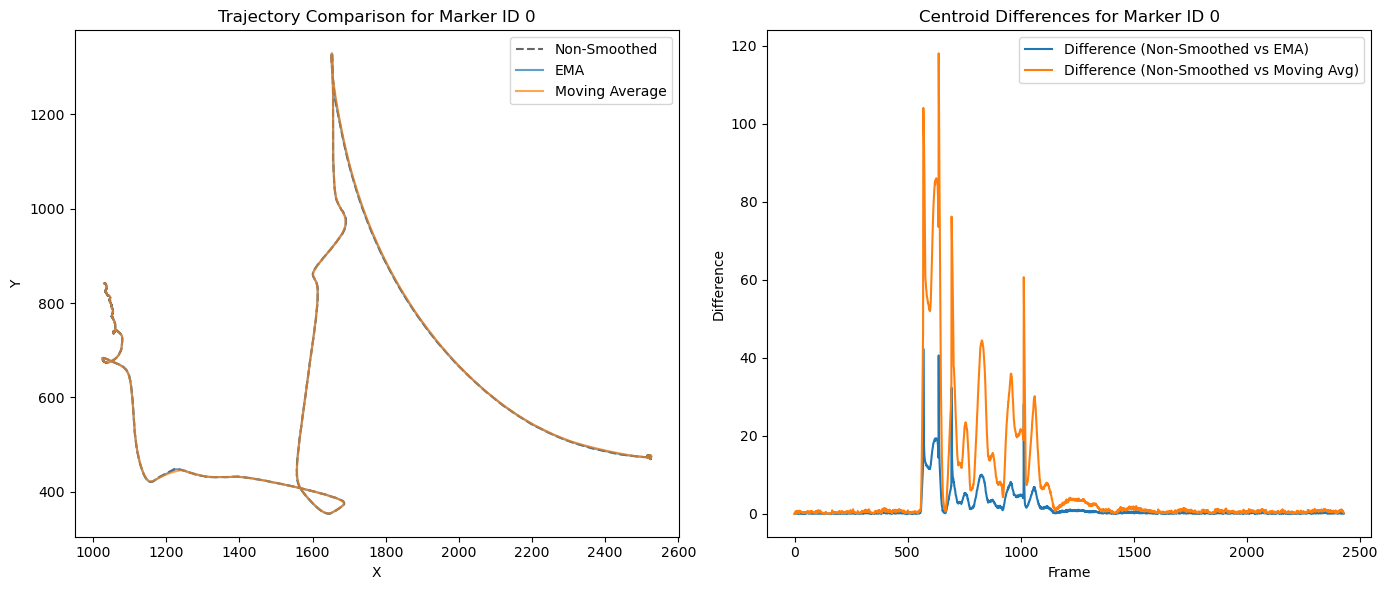

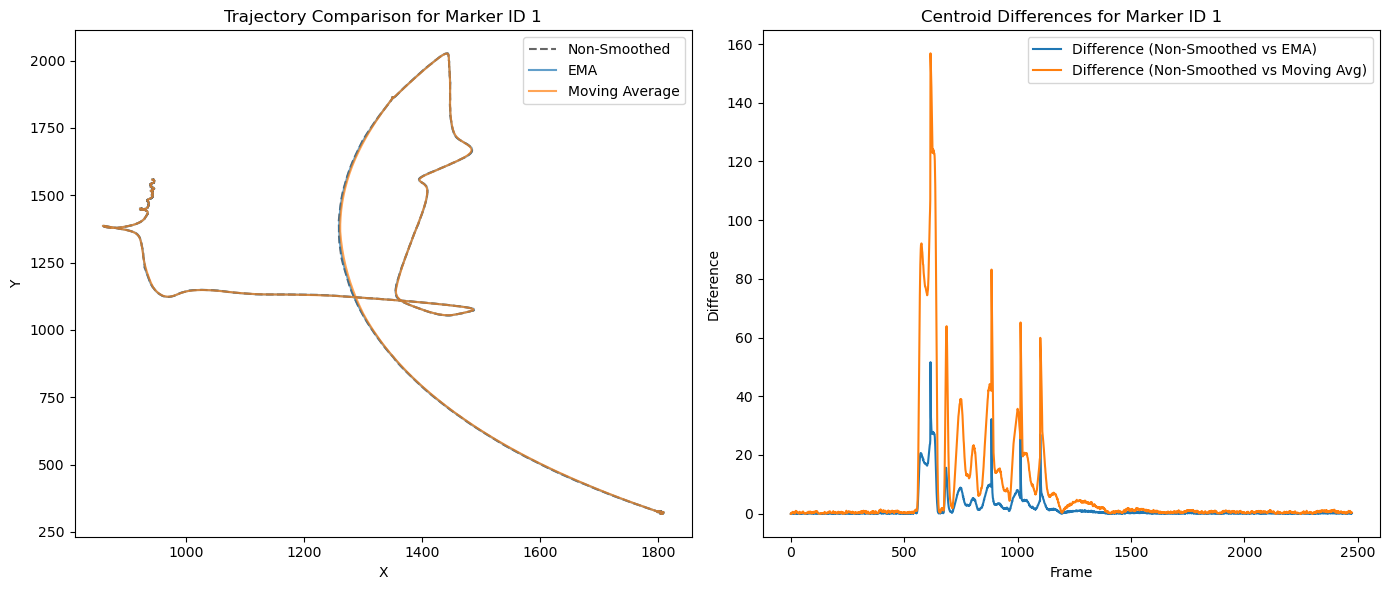

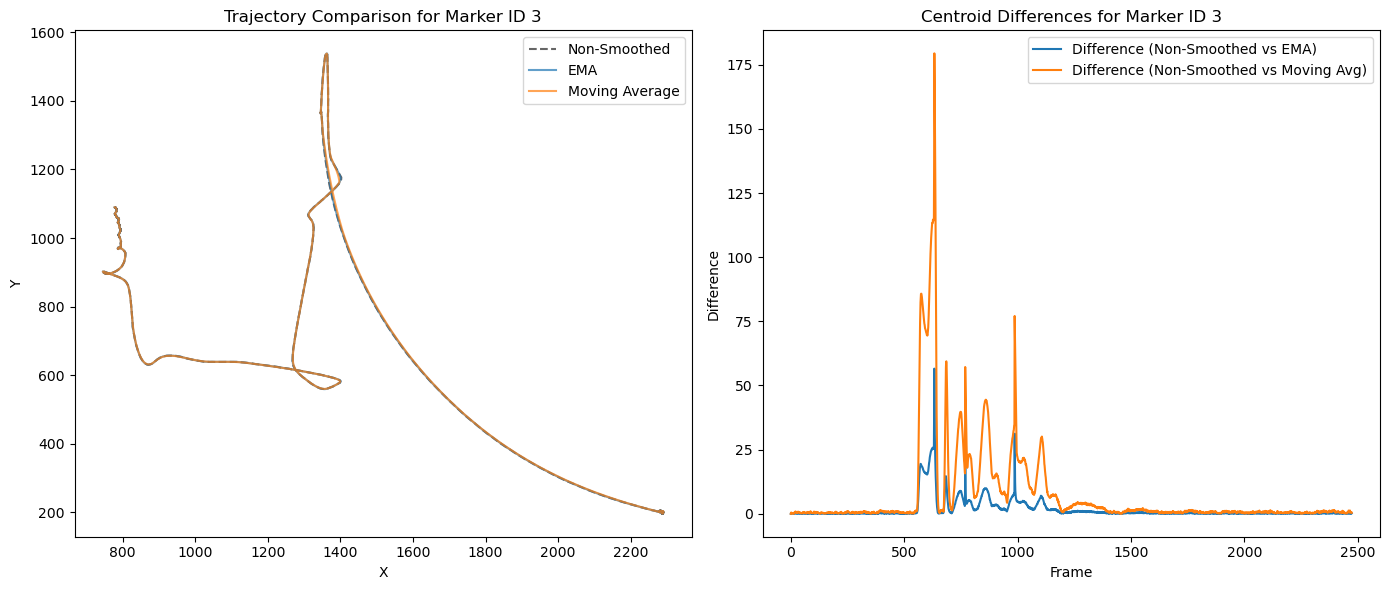

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Load the EMA and Moving Average JSON data
with open('centroids_data_moving_ema.json', 'r') as f_ema, open('centroids_data_wma.json', 'r') as f_moving_avg:
    data_ema = json.load(f_ema)
    data_moving_avg = json.load(f_moving_avg)

# Extract non-smoothed and smoothed centroids
non_smoothed = data_ema['non_smoothed_centroids']  # Non-smoothed is assumed identical in both files
smoothed_ema = data_ema['smoothed_centroids']
smoothed_moving_avg = data_moving_avg['smoothed_centroids']

# IDs to compare
ids_to_compare = ['0', '1', '3']

# Plot for each ID
for id_ in ids_to_compare:
    # Convert data to NumPy arrays
    non_smoothed_data = np.array(non_smoothed[id_])
    ema_data = np.array(smoothed_ema[id_])
    moving_avg_data = np.array(smoothed_moving_avg[id_])

    # Ensure all datasets have the same number of points
    min_len = min(len(non_smoothed_data), len(ema_data), len(moving_avg_data))
    non_smoothed_data = non_smoothed_data[:min_len]
    ema_data = ema_data[:min_len]
    moving_avg_data = moving_avg_data[:min_len]

    # Compute differences
    differences_ema = np.linalg.norm(non_smoothed_data - ema_data, axis=1)
    differences_moving_avg = np.linalg.norm(non_smoothed_data - moving_avg_data, axis=1)

    # Create plots
    plt.figure(figsize=(14, 6))

    # Trajectory plot
    plt.subplot(1, 2, 1)
    plt.plot(non_smoothed_data[:, 0], non_smoothed_data[:, 1], 'k--', label='Non-Smoothed', alpha=0.6)
    plt.plot(ema_data[:, 0], ema_data[:, 1], label='EMA', alpha=0.7)
    plt.plot(moving_avg_data[:, 0], moving_avg_data[:, 1], label='Moving Average', alpha=0.7)
    plt.title(f"Trajectory Comparison for Marker ID {id_}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    # plt.grid()

    # Difference plot
    plt.subplot(1, 2, 2)
    plt.plot(differences_ema, label='Difference (Non-Smoothed vs EMA)')
    plt.plot(differences_moving_avg, label='Difference (Non-Smoothed vs Moving Avg)')
    plt.title(f"Centroid Differences for Marker ID {id_}")
    plt.xlabel("Frame")
    plt.ylabel("Difference")
    plt.legend()
    # plt.grid()

    # Show plots
    plt.tight_layout()
    plt.show()


In [21]:
# output_data

In [17]:
# non_smoothed_data

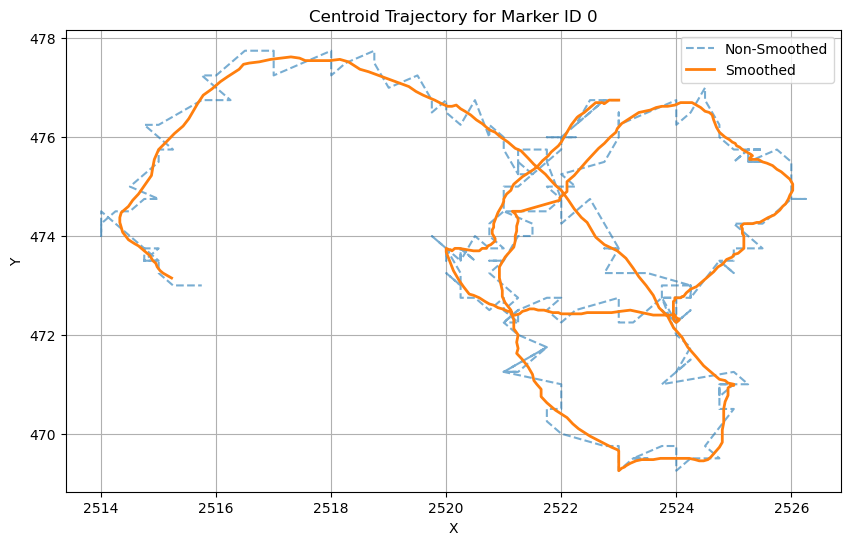

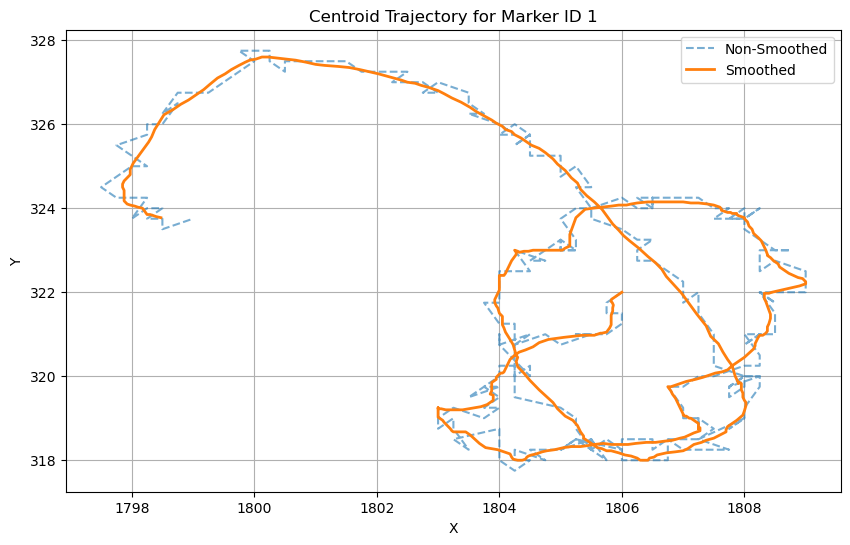

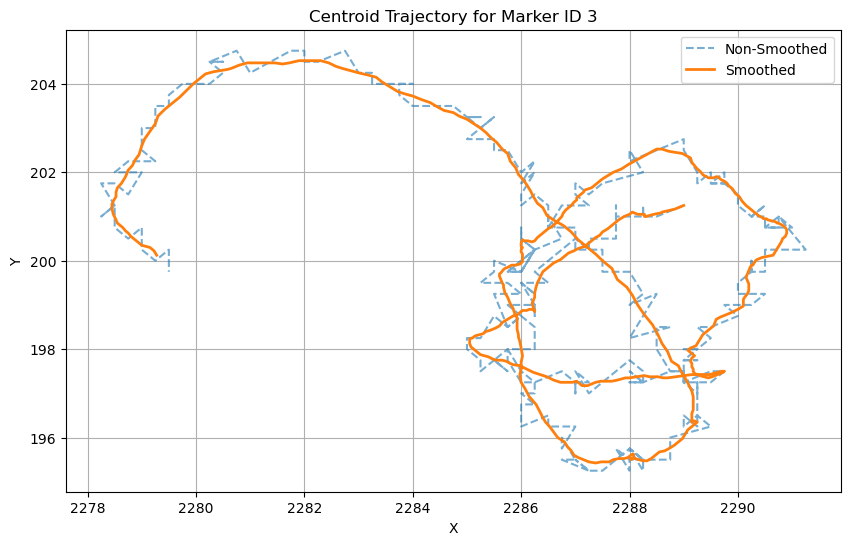

In [23]:
# Load the saved JSON data
with open('centroids_data_moving_avg.json', 'r') as f:
    data = json.load(f)

non_smoothed = data['non_smoothed_centroids']
smoothed = data['smoothed_centroids']

# IDs to plot
ids_to_plot = ['0', '1', '3']

# Plot for each ID
for id_ in ids_to_plot:
    non_smoothed_data = np.array(non_smoothed[id_])
    smoothed_data = np.array(smoothed[id_])

    # Create a new figure for each ID
    plt.figure(figsize=(10, 6))
    plt.plot(non_smoothed_data[:, 0], non_smoothed_data[:, 1], '--', label='Non-Smoothed', alpha=0.6)
    plt.plot(smoothed_data[:, 0], smoothed_data[:, 1], label='Smoothed', linewidth=2)
    
    # Add plot details
    plt.title(f"Centroid Trajectory for Marker ID {id_}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.show()

{3: array([2279.5 ,  199.75], dtype=float32),
 1: array([1799.  ,  323.75], dtype=float32),
 0: array([2515.75,  473.  ], dtype=float32)}

In [16]:
corners_dict

{3: array([[[2292.     ,  219.00006],
         [2261.875  ,  213.37695],
         [2266.9844 ,  181.01562],
         [2296.999  ,  186.50685]]], dtype=float32),
 1: array([[[1779.999  ,  334.24915],
         [1787.9473 ,  304.     ],
         [1817.     ,  312.01575],
         [1809.     ,  344.     ]]], dtype=float32),
 0: array([[[2535.75   ,  464.75024],
         [2523.9995 ,  494.     ],
         [2495.     ,  481.25385],
         [2506.9375 ,  452.0625 ]]], dtype=float32)}

In [8]:
# Load the ArUCo dictionary
aruco_type = cv2.aruco.DICT_4X4_50
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(aruco_type)
ARUCO_PARAMETERS = cv2.aruco.DetectorParameters()

# Specify the valid marker IDs
VALID_IDS = [0, 1, 3]

# Camera calibration parameters (from your data)
camera_matrix = np.array([
    [2809.29850, 0.00000000, 1938.76988],
    [0.00000000, 2794.31693, 982.657080],
    [0.00000000, 0.00000000, 1.00000000]
], dtype=float)

dist_coeffs = np.array([0.06760441, -0.16220928, -0.01206793, 0.00135183, 0.24045989], dtype=float)

# Function to detect ArUco markers in image tiles (tiling detection)
def detect_aruco_markers_in_tiles(frame, tile_size=1200, overlap=0):
    h, w = frame.shape[:2]
    detected_corners = []
    detected_ids = []
    
    for y in range(0, h, tile_size - overlap):
        for x in range(0, w, tile_size - overlap):
            # Adjust tile size for boundary tiles
            tile_w = min(tile_size, w - x)
            tile_h = min(tile_size, h - y)
            tile = frame[y:y + tile_h, x:x + tile_w]
            
            gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
            corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
            
            if ids is not None:
                for corner, id_ in zip(corners, ids):
                    id_scalar = id_[0]
                    if id_scalar in VALID_IDS:
                        # Adjust corner coordinates to the original image
                        corner[:, :, 0] += x
                        corner[:, :, 1] += y
                        
                        detected_corners.append(corner)
                        detected_ids.append(id_scalar)
                    else:
                        print(f"[WARNING] Detection error: Marker ID {id_scalar} is not in {VALID_IDS}.")
    
    if detected_ids:
        detected_ids = np.array(detected_ids)
    else:
        detected_ids = None
    
    return detected_ids, detected_corners

# Initialize dictionaries to store smoothed corners
smoothed_corners_history = {}
alpha = 0.5  # Smoothing factor for exponential moving average (adjust between 0 and 1)

# Open the input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("[ERROR] Unable to open video file.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read the first frame and detect markers
ret, first_frame = cap.read()
if not ret:
    print("[ERROR] Unable to read the first frame.")
    cap.release()
    out.release()
    exit()

# Undistort the first frame
first_frame_undistorted = cv2.undistort(first_frame, camera_matrix, dist_coeffs)

ids0, corners0 = detect_aruco_markers_in_tiles(first_frame_undistorted)
if ids0 is None or len(ids0) < 2:
    print("[ERROR] Not enough valid markers detected in the first frame.")
    cap.release()
    out.release()
    exit()

# Initialize smoothed corners with the first frame's corners
for id_, corner in zip(ids0, corners0):
    smoothed_corners_history[id_] = corner.copy()

# Create a dictionary of marker IDs and their corresponding corner points in the first frame
corners_dict0 = {id_: corner for id_, corner in zip(ids0, corners0)}

# Collect all corner points from the first frame
pts_dst = []
for id_ in ids0:
    pts_dst.extend(corners_dict0[id_][0])

pts_dst = np.array(pts_dst)

# Draw detected markers
cv2.aruco.drawDetectedMarkers(first_frame_undistorted, corners0, ids0)
out.write(first_frame_undistorted)

frame_count = 1
max_frames = 500

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Undistort the frame
    frame_undistorted = cv2.undistort(frame, camera_matrix, dist_coeffs)

    ids, corners = detect_aruco_markers_in_tiles(frame_undistorted)
    if ids is not None and len(ids) >= 2:
        # Apply smoothing to the detected corners
        smoothed_corners = []
        for id_, corner in zip(ids, corners):
            if id_ in smoothed_corners_history:
                # Exponential Moving Average (EMA)
                smoothed_corner = alpha * corner + (1 - alpha) * smoothed_corners_history[id_]
                smoothed_corners_history[id_] = smoothed_corner.copy()
            else:
                # Initialize if not present
                smoothed_corner = corner.copy()
                smoothed_corners_history[id_] = corner.copy()
            smoothed_corners.append(smoothed_corner)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough valid markers detected.")
        out.write(frame_undistorted)
        frame_count += 1
        continue  # Skip to the next frame

    # Create a dictionary of marker IDs and their smoothed corners in the current frame
    corners_dict = {id_: corner for id_, corner in zip(ids, smoothed_corners)}

    # Find common markers between current frame and the first frame
    matched_ids = set(ids0).intersection(set(ids))

    if len(matched_ids) >= 2:
        # Use all corners of matched markers for homography estimation
        pts_src = []
        pts_dst_matched = []
        for id_ in matched_ids:
            pts_src.extend(corners_dict[id_][0])
            pts_dst_matched.extend(corners_dict0[id_][0])

        pts_src = np.array(pts_src)
        pts_dst_matched = np.array(pts_dst_matched)

        # Compute homography
        H, mask = cv2.findHomography(pts_src, pts_dst_matched, cv2.RANSAC)

        if H is not None:
            # Warp the current frame to align with the first frame
            warped_frame = cv2.warpPerspective(frame_undistorted, H, (width, height))

            # Optionally draw markers for debugging
            # cv2.aruco.drawDetectedMarkers(warped_frame, smoothed_corners, ids)

            out.write(warped_frame)
        else:
            print(f"[INFO] Frame {frame_count}: Homography could not be computed.")
            out.write(frame_undistorted)
    else:
        print(f"[INFO] Frame {frame_count}: Not enough matched markers.")
        out.write(frame_undistorted)

    if frame_count % 100 == 0:
        print(f"Processed frame {frame_count}")

    frame_count += 1

# Release video objects
cap.release()
out.release()
print("[INFO] Video processing complete.")

[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 100
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 200
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 300
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
Processed frame 400
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[WARNING] Detection error: Marker ID 17 is not in [0, 1, 3].
[INFO] Video processing complete.


In [5]:
marker_length

0.18

In [14]:
prev_ids,prev_corners

(array([3, 1, 0], dtype=int32),
 [array([[[2302.,  220.],
          [2271.,  215.],
          [2277.,  182.],
          [2306.,  188.]]], dtype=float32),
  array([[[1788.,  333.],
          [1795.,  302.],
          [1825.,  311.],
          [1816.,  342.]]], dtype=float32),
  array([[[2543.,  468.],
          [2532.,  497.],
          [2503.,  486.],
          [2514.,  456.]]], dtype=float32)])

In [15]:
prev_corners_dict

{3: array([[[2292.,  219.],
         [2262.,  213.],
         [2267.,  181.],
         [2297.,  186.]]], dtype=float32),
 1: array([[[1780.,  334.],
         [1788.,  304.],
         [1817.,  312.],
         [1809.,  344.]]], dtype=float32),
 0: array([[[2536.,  465.],
         [2524.,  494.],
         [2495.,  481.],
         [2507.,  452.]]], dtype=float32)}

### Plot histogram of marker area - divide by ID : is there differences? why?

### Plot change of area size over time for each separate marker

### Caculating Euclidean Distance Between Marker Corners and conversion rate

In [7]:
# Real-world known distance
distance_cm = 18.0

# Function to calculate the pixel distance and conversion factor
def calculate_conversion_factors(df):
    # Calculate pixel distance between bottom-left and bottom-right for each frame
    df['bottom_pixel_distance'] = np.sqrt(
        (df['bottom_right_x'] - df['bottom_left_x']) ** 2 +
        (df['bottom_right_y'] - df['bottom_left_y']) ** 2
    )
    
    # Calculate conversion factor (cm per pixel)
    df['conversion_factor'] = distance_cm / df['bottom_pixel_distance']
    
    return df
    
#Appiling the function to the dataframe
df = calculate_conversion_factors(df)

In [8]:
df.head()

,frame,ID,orientation,centroid_x,centroid_y,top_left_x,top_left_y,top_right_x,top_right_y,bottom_right_x,bottom_right_y,bottom_left_x,bottom_left_y,bottom_pixel_distance,conversion_factor
0,0,3,-130.329196,1983,2483,1997,2500,1967,2498,1970,2467,2000,2468,30.016662,0.599667
1,0,0,126.633012,3366,2457,3379,2439,3384,2471,3355,2475,3349,2443,32.557641,0.552866
2,0,1,-43.090847,2833,2494,2849,2480,2848,2510,2818,2509,2820,2478,31.064449,0.579441
3,1,3,-130.329196,1983,2483,1997,2500,1967,2498,1970,2467,2000,2468,30.016662,0.599667
4,1,0,125.892848,3366,2457,3378,2439,3384,2471,3354,2475,3349,2443,32.388269,0.555757


### Bottom pixel distance change over time

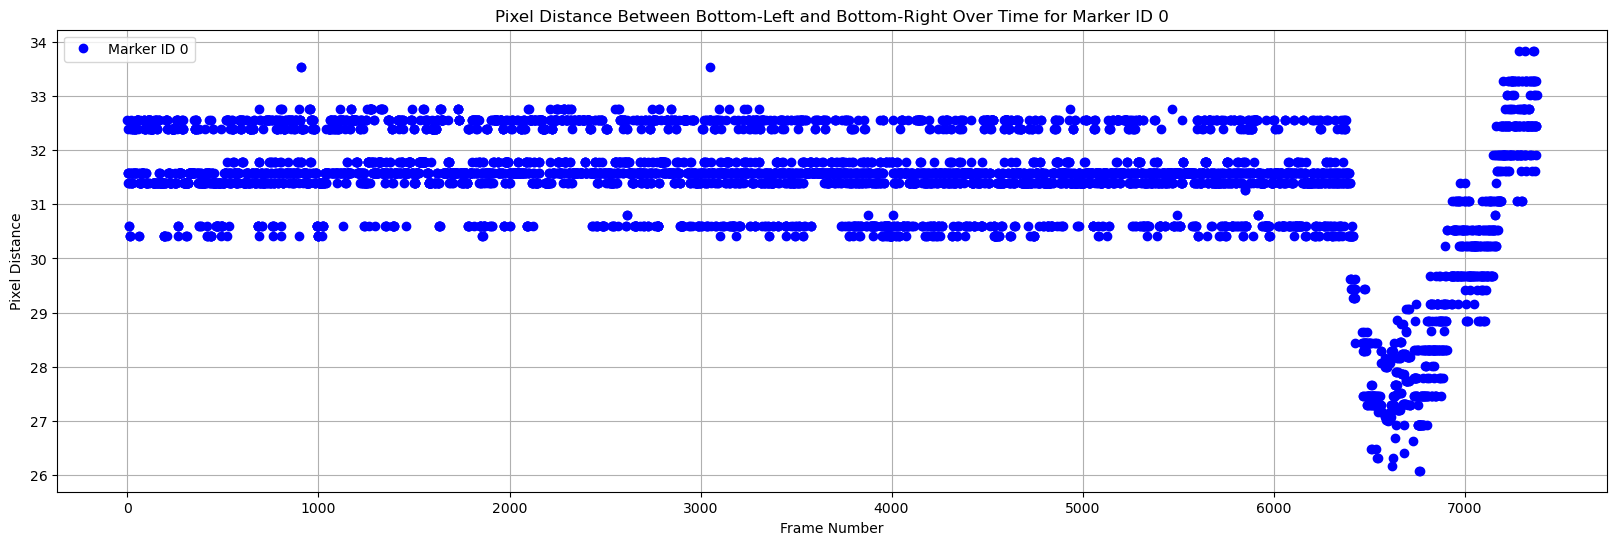

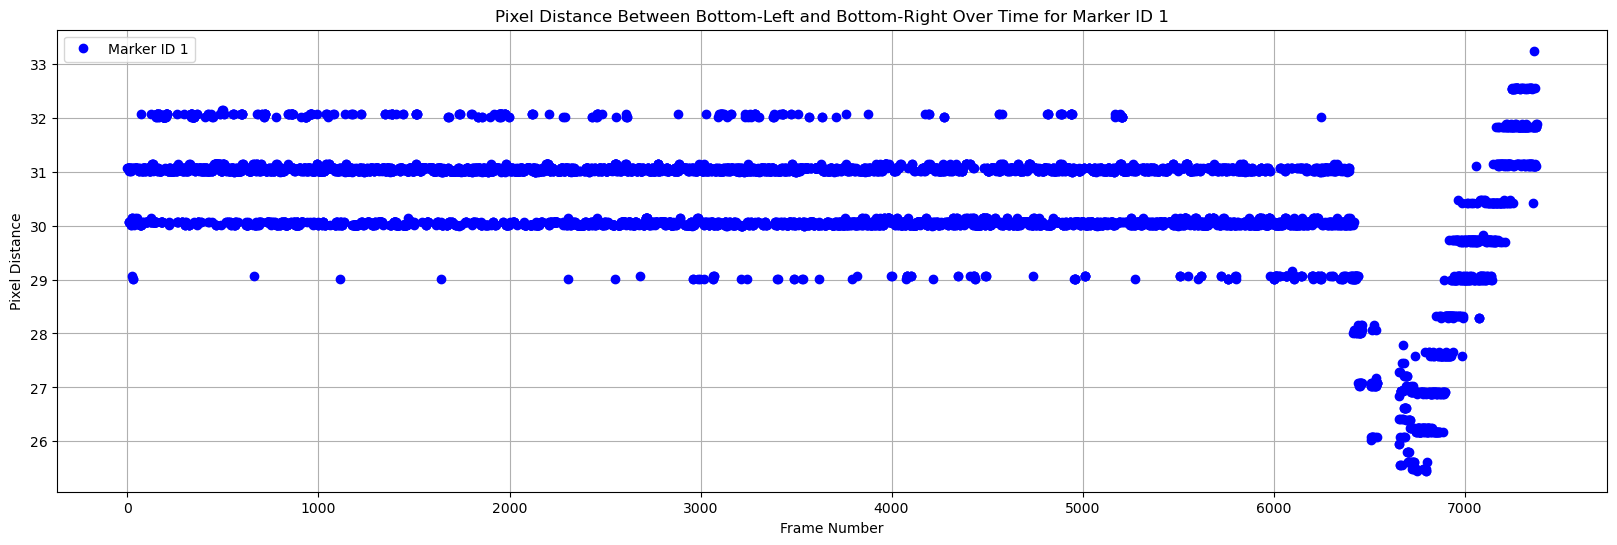

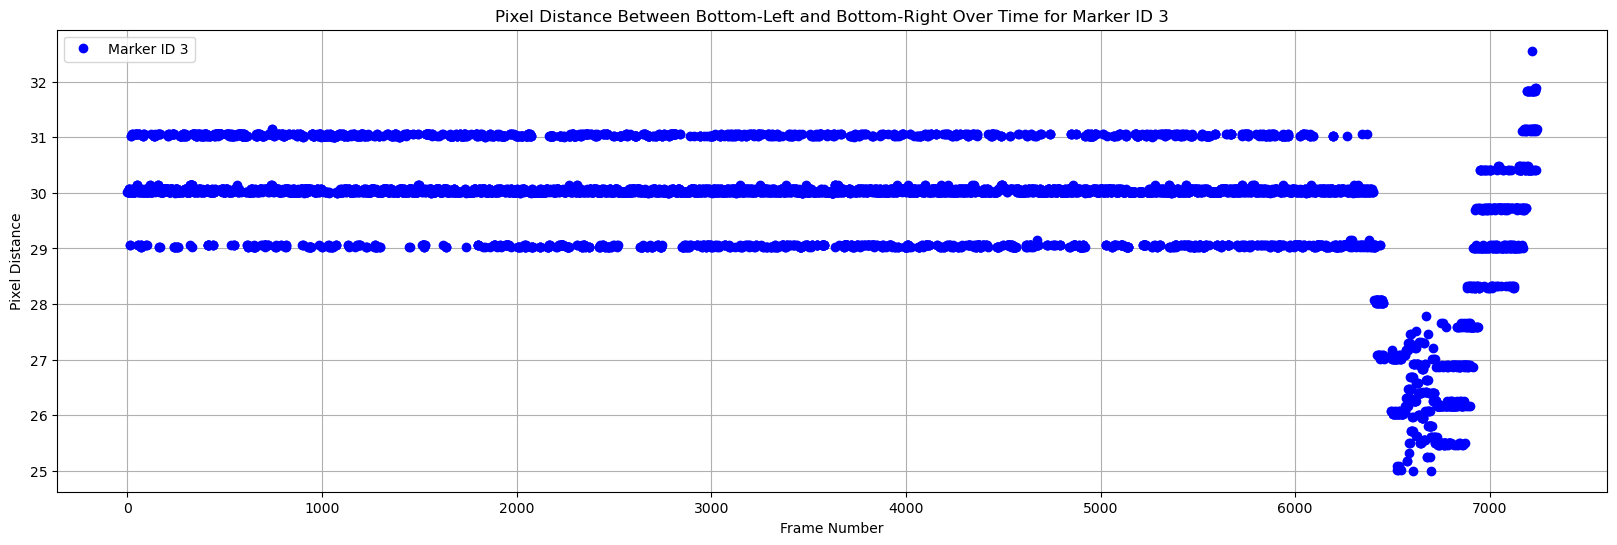

In [9]:
# Filter the DataFrame for IDs 0, 1, and 3 because an error causes random adtional markers to apprear
filtered_df = df[df['ID'].isin([0, 1, 3])]
# Plotting the pixel distance over time
for marker_id in [0, 1, 3]:
    df_marker = filtered_df[filtered_df['ID'] == marker_id]
    
    plt.figure(figsize=(20, 6))
    plt.plot(df_marker['frame'], df_marker['bottom_pixel_distance'],"o", label=f'Marker ID {marker_id}', color='blue')
    
    plt.title(f'Pixel Distance Between Bottom-Left and Bottom-Right Over Time for Marker ID {marker_id}')
    plt.xlabel('Frame Number')
    plt.ylabel('Pixel Distance')
    plt.grid(True)
    plt.legend()
    plt.show()

### Correlate Distance with Drone Altitude


In [10]:
# Save the dataframe to an HDF5 file to your folder defined in output_h5_path
df.to_hdf(output_h5_path, key='df', mode='w')
print("[INFO] Data saved to HDF5 file.")

[INFO] Data saved to HDF5 file.


In [30]:
import cv2
import numpy as np
import pandas as pd

# Load the DataFrame with Aruco marker corner points
video_path = 'E:/sophia/files/videofiles/20240305_065328211_DJI_0260.MP4'

# Ensure the 'frame' column is of integer type
df['frame'] = df['frame'].astype(int)

# Extract points from the first frame as the reference (frame number 0)
first_frame_corners = df[df['frame'] == 0]

# Check if data for the first frame exists
if first_frame_corners.empty:
    print("Error: No data for the first frame (frame number 0).")
    exit()

# Define marker IDs to use and filter out Marker ID 1 if missing
marker_ids = [0, 3]  # Define markers to use (excluding Marker ID 1)

# Group by marker ID and get the corners for the first frame
points_first_frame = []
for marker_id in marker_ids:
    marker_data = first_frame_corners[first_frame_corners['ID'] == marker_id]
    if not marker_data.empty:
        points_first_frame.append(marker_data[['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y',
                                               'bottom_left_x', 'bottom_left_y', 'bottom_right_x', 'bottom_right_y']].values.flatten())

if len(points_first_frame) == 0:
    print("Error: No valid marker data available for the first frame.")
    exit()

points_first_frame = np.array(points_first_frame).reshape(-1, 2)

# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Unable to open video file '{video_path}'.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video properties: FPS={fps}, Width={frame_width}, Height={frame_height}")

# Define video codec and create VideoWriter to save output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
output_video = cv2.VideoWriter('E:/sophia/files/videofiles/20240305_065328211_DJI_0260_aligned_video.mp4', fourcc, fps, (frame_width, frame_height))

# Store the homography matrices
homographies = []

# Define the frame range to save in the output video
start_frame = 6500
end_frame = 6900

# Initialize frame number and processed frames counter
frame_num = 0
processed_frames = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("End of video or error reading frame.")
        break

    # Print frame number to debug progress
    if frame_num % 100 == 0:
        print(f"Processing frame {frame_num}")

    if start_frame <= frame_num < end_frame:
        # Get marker points for the current frame from the DataFrame
        current_frame_corners = df[(df['frame'] == frame_num) & (df['ID'].isin(marker_ids))]

        if len(current_frame_corners) == 0:
            # If no markers for this frame, store identity homography
            homographies.append(np.eye(3))
        else:
            # Extract points from the current frame
            points_current_frame = []
            for marker_id in marker_ids:
                marker_data = current_frame_corners[current_frame_corners['ID'] == marker_id]
                if not marker_data.empty:
                    points_current_frame.append(marker_data[['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y',
                                                             'bottom_left_x', 'bottom_left_y', 'bottom_right_x', 'bottom_right_y']].values.flatten())

            if len(points_current_frame) == 0:
                # If no valid points for this frame, store identity homography
                homographies.append(np.eye(3))
            else:
                points_current_frame = np.array(points_current_frame).reshape(-1, 2)

                # Ensure the number of points matches
                if points_current_frame.shape[0] != points_first_frame.shape[0]:
                    print("Warning: Number of points in current frame does not match the first frame.")
                    homographies.append(np.eye(3))
                else:
                    # Compute the homography matrix between the current frame and the first frame
                    H, _ = cv2.findHomography(points_current_frame, points_first_frame, method=cv2.RANSAC)

                    # Store the homography matrix for future use
                    homographies.append(H)

                    # Warp and save the frames in the specified range
                    aligned_frame = cv2.warpPerspective(frame, H, (frame_width, frame_height))
                    output_video.write(aligned_frame)
                    processed_frames += 1

    frame_num += 1

# Release video objects
cap.release()
output_video.release()
cv2.destroyAllWindows()

# Save homography matrices to a file (optional)
np.save('homographies.npy', homographies)

print(f"Processed {processed_frames} frames. Aligned video from frames {start_frame} to {end_frame} saved as '20240305_065328211_DJI_0260_aligned_video.mp4'.")


Video properties: FPS=50.0, Width=5120, Height=2700
Processing frame 0
Processing frame 100
Processing frame 200
Processing frame 300
Processing frame 400
Processing frame 500
Processing frame 600
Processing frame 700
Processing frame 800
Processing frame 900
Processing frame 1000
Processing frame 1100
Processing frame 1200
Processing frame 1300
Processing frame 1400
Processing frame 1500
Processing frame 1600
Processing frame 1700
Processing frame 1800
Processing frame 1900
Processing frame 2000
Processing frame 2100
Processing frame 2200
Processing frame 2300
Processing frame 2400
Processing frame 2500
Processing frame 2600
Processing frame 2700
Processing frame 2800
Processing frame 2900
Processing frame 3000
Processing frame 3100
Processing frame 3200
Processing frame 3300
Processing frame 3400
Processing frame 3500
Processing frame 3600
Processing frame 3700
Processing frame 3800
Processing frame 3900
Processing frame 4000
Processing frame 4100
Processing frame 4200
Processing fra

In [29]:
# Define the frame range and marker ID
start_frame = 6550
end_frame = 6590
marker_id = 0

# Filter the DataFrame for frames in the specified range and ID
filtered_df = df[(df['frame'] >= start_frame) & (df['frame'] <= end_frame) & (df['ID'] == marker_id)]

# Print or inspect the filtered DataFrame
print(filtered_df)


       frame  ID  orientation  centroid_x  centroid_y  top_left_x  top_left_y  \
19553   6550   0   126.767570        3204        2353        3215        2338   
19555   6551   0   126.767570        3203        2354        3214        2339   
19557   6552   0   126.767570        3202        2355        3213        2340   
19559   6553   0   125.689209        3200        2356        3212        2341   
19561   6554   0   126.413435        3199        2358        3211        2343   
19563   6555   0   127.643975        3197        2359        3209        2344   
19565   6556   0   126.767570        3196        2360        3207        2345   
19567   6557   0   126.573029        3194        2362        3206        2347   
19569   6558   0   127.616422        3192        2364        3204        2349   
19571   6559   0   125.540776        3190        2365        3201        2350   
19573   6560   0   127.643975        3188        2367        3199        2352   
19575   6561   0   126.57302